In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#plot_n_b_psth.ipynb
#plot neural and behavior psth

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
# import random

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

%matplotlib notebook

In [3]:
%matplotlib notebook

In [ ]:
#See check_command_binning_v2.ipynb for visualizing binning the command

In [4]:
#LOAD AND UNPACK DATA: 

# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\command_compare'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

True


In [5]:
#Pre-processing: 

bmi_b.preprocess_bmi_df(df, target_pos, pre, num_tasks, num_targets)

#Binning: 

#MAGNITUDE:
num_mag_bins = 4
mag_bin_perc = np.array([0,25,50,75,100])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df, mag_bin_perc, num_angle_bins, T0_angle)
#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df, angle_bin)
#BIN: 
bmi_b.df_bin_command(df, mag_bin_edges,angle_bin_edges)

#Pre-processing continued:

#Center angles to command bin, target: 
bmi_b.center_df_angle(df, angle_bin_c, target_angle)

('angle_center:', 22.5)
('min centered angle:', -157.4975492637699)
('max centered angle:', 202.46708261619673)


In [6]:
df.head()

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,d2target,x_error,y_error,u_v_mag_bin,u_v_angle_bin,p_angle_ctr_t,v_angle_ctr_t,u_p_angle_ctr_t,u_v_angle_ctr_t,u_v_angle_ctr_bin
0,2.0,1.0,0.0,0.0,1.0,4.0,2.0,0.0,0.0,0.0,...,18.560671,13.435452,12.805746,1.0,5.0,0.733399,-5.024228,-4.379982,-4.379982,1.903203
1,2.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,18.844048,13.533209,13.112986,3.0,5.0,0.751804,-5.020172,-4.939422,-4.939422,1.343763
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,19.180040,13.683511,13.440069,2.0,4.0,0.766647,-5.167754,-5.175365,-5.175365,1.107820
3,5.0,0.0,0.0,1.0,0.0,4.0,4.0,0.0,0.0,0.0,...,19.319563,13.790328,13.530425,1.0,1.0,0.765679,0.425349,-1.608672,-1.608672,-1.608672
4,4.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,...,19.482174,13.903848,13.646909,1.0,5.0,0.766238,-5.440931,-5.080391,-5.080391,1.202795


In [109]:
def plot_command_bin(angle_linewidth=3): 
    bmi_b.plot_polar_bins(angle_bin_edges, mag_bin_edges, target_color, angle_linewidth)

<IPython.core.display.Javascript object>


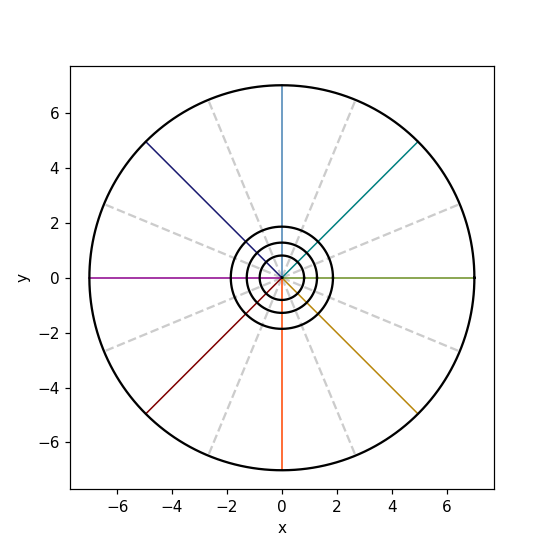

In [110]:
plt.figure(figsize=(5,5))
plot_command_bin(angle_linewidth=1)

### Test getting shuffling subsets

In [20]:
#we will use index and row interchangeably.

#Confirm index matches row number: 
any(df.index.values != np.arange(df.shape[0]))
    

False

In [43]:
num_shuffle = 1000
start_bound = 5 # how many samples away from beginning or end of trial you need to be:
stop_bound = 5

#condition-command: task,target,mag,angle
r = {}
sel_bin = (df['bin']>=start_bound) & (df['bin_end']>=stop_bound)
for bm in range(num_mag_bins):
    for ba in range(num_angle_bins):
        sel_bm = df['u_v_mag_bin']==bm
        sel_ba = df['u_v_angle_bin']==ba
        sel_command = \
            sel_bin&\
            sel_bm&sel_ba
        command_idxs = np.where(sel_command)[0]
        num_obs_command = len(command_idxs)
        
        for target in range(num_targets):
            for task in range(num_tasks):
                sel_target = df['target']==target
                sel_task = df['task']==task
                sel_cond = \
                sel_command&\
                sel_target&sel_task
                cond_command_idxs = np.where(sel_cond)[0] 
                num_obs_cond = len(cond_command_idxs)
                print('cond:', task, target, 'command:', bm, ba, 'num obs:', num_obs_cond)
                
                #Generate the shuffle selections: 
                shuffle_mat = np.ones((num_obs_cond,num_shuffle))*np.nan
                for s in range(num_shuffle):
                    shuffle_mat[:,s] = np.random.choice(command_idxs, num_obs_cond,replace=False)
                
                #ASSIGN:
                r['command',bm,ba,'num_obs'] = num_obs_command
                r[task,target,bm,ba,'num_obs'] = num_obs_cond
                r[task,target,bm,ba,'shuffle'] = shuffle_mat

('cond:', 0, 0, 'command:', 0, 0, 'num obs:', 8)
('cond:', 1, 0, 'command:', 0, 0, 'num obs:', 24)
('cond:', 0, 1, 'command:', 0, 0, 'num obs:', 14)
('cond:', 1, 1, 'command:', 0, 0, 'num obs:', 33)
('cond:', 0, 2, 'command:', 0, 0, 'num obs:', 13)
('cond:', 1, 2, 'command:', 0, 0, 'num obs:', 31)
('cond:', 0, 3, 'command:', 0, 0, 'num obs:', 2)
('cond:', 1, 3, 'command:', 0, 0, 'num obs:', 28)
('cond:', 0, 4, 'command:', 0, 0, 'num obs:', 4)
('cond:', 1, 4, 'command:', 0, 0, 'num obs:', 45)
('cond:', 0, 5, 'command:', 0, 0, 'num obs:', 3)
('cond:', 1, 5, 'command:', 0, 0, 'num obs:', 12)
('cond:', 0, 6, 'command:', 0, 0, 'num obs:', 2)
('cond:', 1, 6, 'command:', 0, 0, 'num obs:', 3)
('cond:', 0, 7, 'command:', 0, 0, 'num obs:', 1)
('cond:', 1, 7, 'command:', 0, 0, 'num obs:', 13)
('cond:', 0, 0, 'command:', 0, 1, 'num obs:', 4)
('cond:', 1, 0, 'command:', 0, 1, 'num obs:', 24)
('cond:', 0, 1, 'command:', 0, 1, 'num obs:', 14)
('cond:', 1, 1, 'command:', 0, 1, 'num obs:', 38)
('cond:'

('cond:', 0, 5, 'command:', 1, 2, 'num obs:', 2)
('cond:', 1, 5, 'command:', 1, 2, 'num obs:', 8)
('cond:', 0, 6, 'command:', 1, 2, 'num obs:', 0)
('cond:', 1, 6, 'command:', 1, 2, 'num obs:', 0)
('cond:', 0, 7, 'command:', 1, 2, 'num obs:', 0)
('cond:', 1, 7, 'command:', 1, 2, 'num obs:', 4)
('cond:', 0, 0, 'command:', 1, 3, 'num obs:', 1)
('cond:', 1, 0, 'command:', 1, 3, 'num obs:', 5)
('cond:', 0, 1, 'command:', 1, 3, 'num obs:', 5)
('cond:', 1, 1, 'command:', 1, 3, 'num obs:', 18)
('cond:', 0, 2, 'command:', 1, 3, 'num obs:', 19)
('cond:', 1, 2, 'command:', 1, 3, 'num obs:', 45)
('cond:', 0, 3, 'command:', 1, 3, 'num obs:', 18)
('cond:', 1, 3, 'command:', 1, 3, 'num obs:', 85)
('cond:', 0, 4, 'command:', 1, 3, 'num obs:', 19)
('cond:', 1, 4, 'command:', 1, 3, 'num obs:', 68)
('cond:', 0, 5, 'command:', 1, 3, 'num obs:', 4)
('cond:', 1, 5, 'command:', 1, 3, 'num obs:', 19)
('cond:', 0, 6, 'command:', 1, 3, 'num obs:', 0)
('cond:', 1, 6, 'command:', 1, 3, 'num obs:', 1)
('cond:', 0,

('cond:', 1, 2, 'command:', 2, 5, 'num obs:', 6)
('cond:', 0, 3, 'command:', 2, 5, 'num obs:', 5)
('cond:', 1, 3, 'command:', 2, 5, 'num obs:', 31)
('cond:', 0, 4, 'command:', 2, 5, 'num obs:', 21)
('cond:', 1, 4, 'command:', 2, 5, 'num obs:', 92)
('cond:', 0, 5, 'command:', 2, 5, 'num obs:', 16)
('cond:', 1, 5, 'command:', 2, 5, 'num obs:', 64)
('cond:', 0, 6, 'command:', 2, 5, 'num obs:', 2)
('cond:', 1, 6, 'command:', 2, 5, 'num obs:', 6)
('cond:', 0, 7, 'command:', 2, 5, 'num obs:', 1)
('cond:', 1, 7, 'command:', 2, 5, 'num obs:', 5)
('cond:', 0, 0, 'command:', 2, 6, 'num obs:', 1)
('cond:', 1, 0, 'command:', 2, 6, 'num obs:', 13)
('cond:', 0, 1, 'command:', 2, 6, 'num obs:', 0)
('cond:', 1, 1, 'command:', 2, 6, 'num obs:', 2)
('cond:', 0, 2, 'command:', 2, 6, 'num obs:', 2)
('cond:', 1, 2, 'command:', 2, 6, 'num obs:', 2)
('cond:', 0, 3, 'command:', 2, 6, 'num obs:', 1)
('cond:', 1, 3, 'command:', 2, 6, 'num obs:', 8)
('cond:', 0, 4, 'command:', 2, 6, 'num obs:', 4)
('cond:', 1, 4

('cond:', 1, 6, 'command:', 3, 7, 'num obs:', 68)
('cond:', 0, 7, 'command:', 3, 7, 'num obs:', 45)
('cond:', 1, 7, 'command:', 3, 7, 'num obs:', 143)


In [112]:
#Calculate the neural means: 
#command, global
#command, condition
#command, condition, shuffle, i
n_list = ['n_'+str(i) for i in range(num_neurons)]
u_list = ['u_vx', 'u_vy']

sel_bin = (df['bin']>=start_bound) & (df['bin_end']>=stop_bound)
for bm in range(num_mag_bins):
    for ba in range(num_angle_bins):
        sel_bm = df['u_v_mag_bin']==bm
        sel_ba = df['u_v_angle_bin']==ba
        sel_command = \
            sel_bin&\
            sel_bm&sel_ba        
        
        #GLOBAL:
        n_mean = np.array(df.loc[sel_command, n_list]).mean(axis=0)
        r['n_mean', 'global', 'command', bm, ba] = n_mean
        
        #also save the u_vx, u_vy: 
        u_mean = np.array(df.loc[sel_command, u_list]).mean(axis=0)
        r['u_mean', 'global', 'command', bm, ba] = u_mean
        
        
        for target in range(num_targets):
            for task in range(num_tasks):
                sel_target = df['target']==target
                sel_task = df['task']==task
                
                #COND SPECIFIC:
                sel_cond = \
                sel_command&\
                sel_target&sel_task
                
                n_mean = np.array(df.loc[sel_cond, n_list]).mean(axis=0)
                r['n_mean', 'cond', task, target, 'command', bm, ba] = n_mean

                #also save the u_vx, u_vy: 
                u_mean = np.array(df.loc[sel_command, u_list]).mean(axis=0)
                r['u_mean', 'cond', task, target, 'command', bm, ba] = u_mean                
                
        

c:\anaconda3\envs\py2\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice.
c:\anaconda3\envs\py2\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [ ]:
#FOR FUN: 
#Plot the mean activity for each command in PC space
#Plot the image for each neuron as fn of bm, ba

In [115]:
#collect the means for analysis:
min_trials_analyze = 15
var = n_list+u_list
num_var = num_neurons + len(u_list)
nan_mat = np.ones((num_var, num_mag_bins, num_angle_bins, num_tasks, num_targets))*np.nan
da = xr.DataArray(nan_mat,
            coords={'var':var,
                   'bm':range(num_mag_bins),
                   'ba':range(num_angle_bins),
                   'task':range(num_tasks),
                   'target':range(num_targets)},
            dims=['var','bm','ba','task','target'])

for bm in range(num_mag_bins):
    for ba in range(num_angle_bins):
        for target in range(num_targets):
            for task in range(num_tasks):        
                if r[task,target,bm,ba,'num_obs'] >= min_trials_analyze:
                    da.loc[n_list,bm,ba,task,target] = \
                    r['n_mean', 'cond', task, target, 'command', bm, ba]
                    
                    da.loc[u_list,bm,ba,task,target] = \
                    r['u_mean', 'cond', task, target, 'command', bm, ba]                    


In [ ]:
#GLOBAL MEANS: 
#
#NEURONS:
nan_mat = np.ones((num_neurons, num_mag_bins, num_angle_bins, num_tasks, num_targets))*np.nan
n_da = xr.DataArray(nan_mat,
            coords={'n':n_list,
                   'bm':range(num_mag_bins),
                   'ba':range(num_angle_bins),
                   'task':range(num_tasks),
                   'target':range(num_targets)},
            dims=['n','bm','ba','task','target'])


nan_mat = np.ones((len(u_list), num_mag_bins, num_angle_bins, num_tasks, num_targets))*np.nan
u_da = xr.DataArray(nan_mat,
            coords={'u':u_list,
                   'bm':range(num_mag_bins),
                   'ba':range(num_angle_bins),
                   'task':range(num_tasks),
                   'target':range(num_targets)},
            dims=['n','bm','ba','task','target'])

for bm in range(num_mag_bins):
    for ba in range(num_angle_bins):
        n_da[:,bm,ba] = r['n_mean', 'global', 'command', bm, ba]
        u_da[:,bm,ba] = r['u_mean', 'global', 'command', bm, ba]

In [95]:
# #Just for global mean: 
# nan_mat = np.ones((num_neurons, num_mag_bins, num_angle_bins))*np.nan
# n_da = xr.DataArray(nan_mat,
#             coords={'n':n_list,
#                    'bm':range(num_mag_bins),
#                    'ba':range(num_angle_bins)},
#             dims=['n','bm','ba'])


# nan_mat = np.ones((len(u_list), num_mag_bins, num_angle_bins))*np.nan
# u_da = xr.DataArray(nan_mat,
#             coords={'u':u_list,
#                    'bm':range(num_mag_bins),
#                    'ba':range(num_angle_bins)},
#             dims=['u','bm','ba'])

# for bm in range(num_mag_bins):
#     for ba in range(num_angle_bins):
#         n_da[:,bm,ba] = r['n_mean', 'global', 'command', bm, ba]
#         u_da[:,bm,ba] = r['u_mean', 'global', 'command', bm, ba]

### Visualize activity means:

In [59]:
from sklearn.decomposition import PCA

In [139]:
#Figure out PC's, then project on them in a for loop
a = np.array(da.loc[n_list,:,:,:,:]).reshape((44,-1))
nan_cols = np.where(np.isnan(a[0,:]))
a = np.delete(a, nan_cols, axis=1)
a_T = a.T
# plt.figure(figsize=(8,3))
# plt.imshow(a)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [151]:
#DO PCA: 
n_components=2
pca_global = False
if pca_global: 
    n_reshape = np.array(n_da).reshape((num_neurons,-1)).T
    pca = PCA(n_components=n_components)
    pca.fit(n_reshape)
else:
    pca = PCA(n_components=n_components)
    pca.fit(a_T)

In [141]:
da.shape

(46L, 4L, 8L, 2L, 8L)

<IPython.core.display.Javascript object>


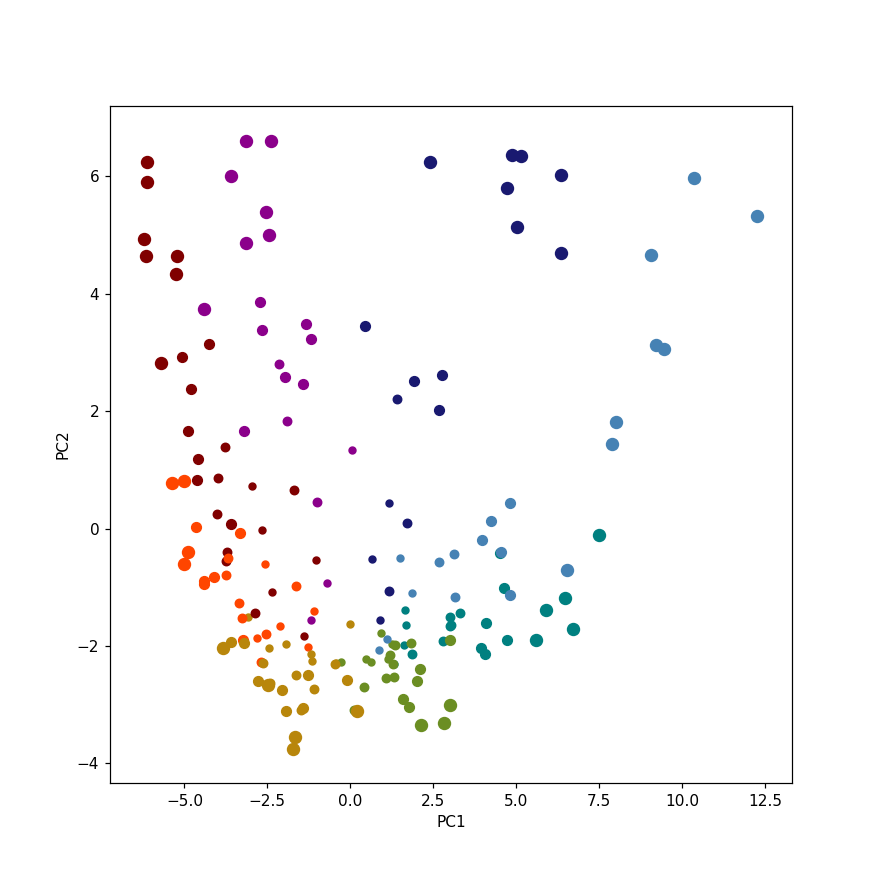

Text(0,0.5,'PC2')

In [155]:
#for loop, project each data point: 

plt.figure(figsize=(8,8))
for bm in range(num_mag_bins):
    for ba in range(num_angle_bins):
        for target in range(num_targets):
            for task in range(num_tasks):
                if r[task,target,bm,ba,'num_obs'] >= min_trials_analyze:
                    d = np.array(da.loc[n_list,bm,ba,task,target]).reshape((-1,1)).T
                    proj = pca.transform(d)
#                     print(proj.shape)
                    #Scatter:
                    plt.scatter(proj[0,0], proj[0,1], color=target_color[ba], s=size_list[bm])
plt.xlabel('PC1')
plt.ylabel('PC2')

In [148]:
n_reshape = np.array(n_da).reshape((num_neurons,-1)).T
n_components=4
pca = PCA(n_components=n_components)
pca.fit(n_reshape)
test = pca.transform(n_reshape).T
test = test.reshape((n_components, num_mag_bins, num_angle_bins))

<IPython.core.display.Javascript object>


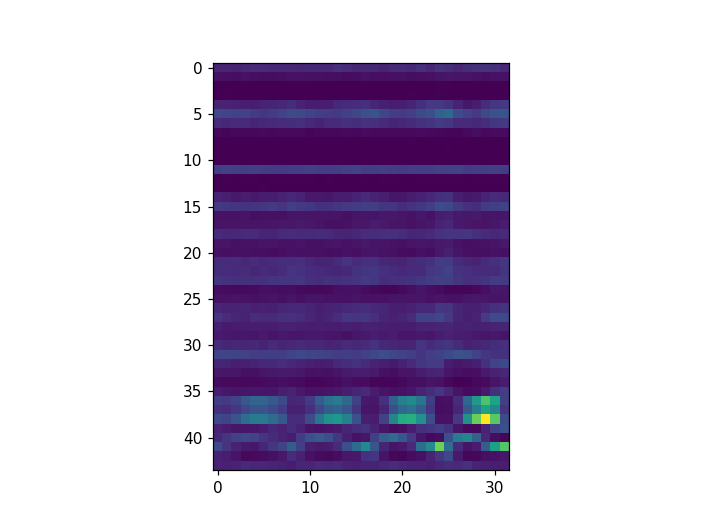

<IPython.core.display.Javascript object>


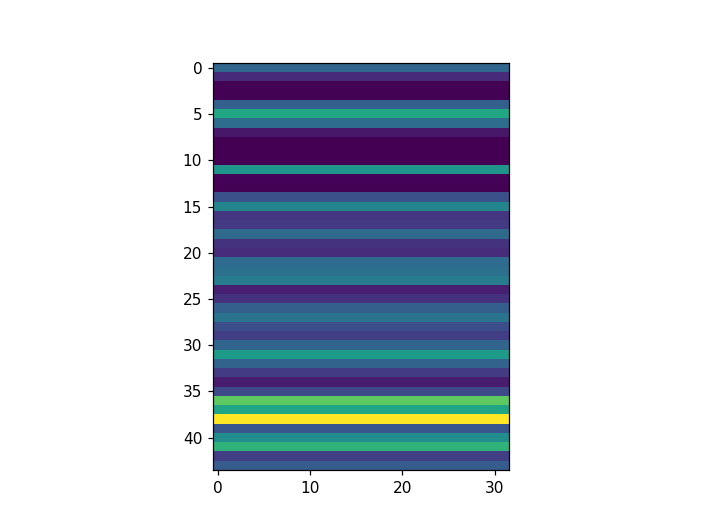

<IPython.core.display.Javascript object>


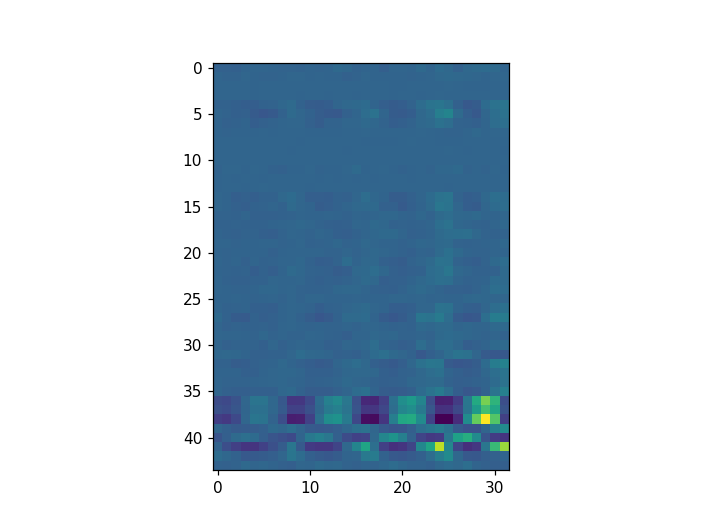

In [138]:
n_plot = n_reshape.T
center = n_plot.mean(axis=1)
center_mat = np.repeat(center.reshape((-1,1)), n_plot.shape[1], axis=1)
n_plot_c = n_plot-center_mat

plt.figure()
plt.imshow(n_plot)

plt.figure()
plt.imshow(center_mat)

plt.figure()
plt.imshow(n_plot_c)

In [68]:
print(pca.explained_variance_ratio_)

[0.63292737 0.31097657]


<IPython.core.display.Javascript object>


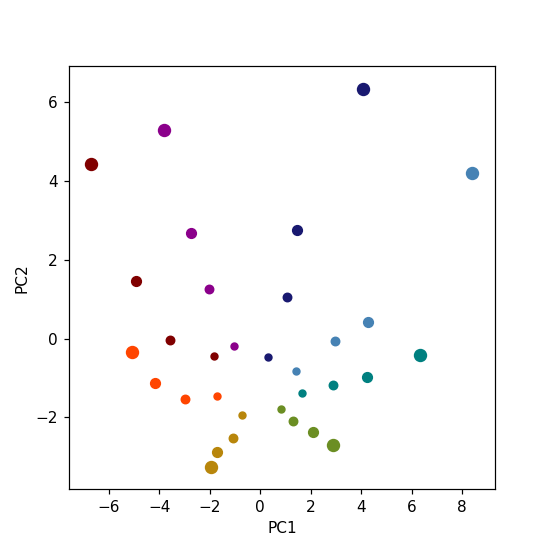

Text(0,0.5,'PC2')

In [96]:
size_list = [20,30,40,60]
plt.figure(figsize=(5,5))
for bm in range(num_mag_bins):
    for ba in range(num_angle_bins):
        plt.scatter(test[0,bm,ba], test[1,bm,ba], color=target_color[ba], s=size_list[bm])
plt.xlabel('PC1')
plt.ylabel('PC2')

<IPython.core.display.Javascript object>


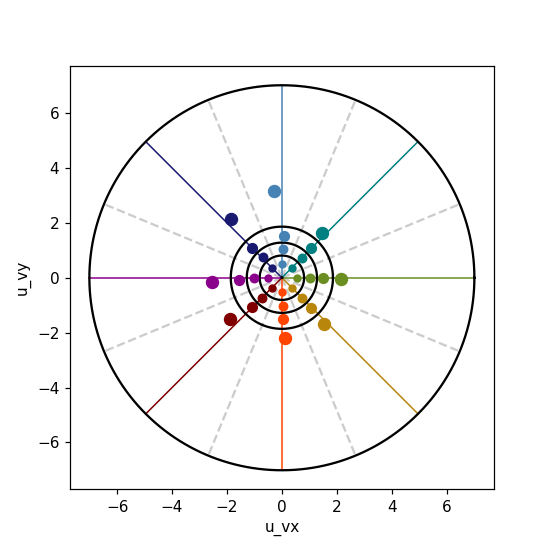

Text(0,0.5,'u_vy')

In [111]:
plt.figure(figsize=(5,5))
plot_command_bin(angle_linewidth=1)
for bm in range(num_mag_bins):
    for ba in range(num_angle_bins):
        plt.scatter(\
                    u_da.loc['u_vx',bm,ba], u_da.loc['u_vy',bm,ba],\
                    color=target_color[ba], s=size_list[bm])
                    #edgecolor=np.ones(3)*0.8, linewidth=2)
plt.xlabel('u_vx')
plt.ylabel('u_vy')

<IPython.core.display.Javascript object>


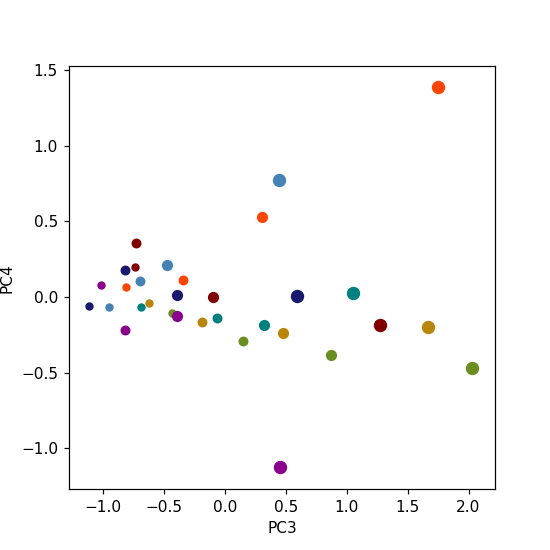

Text(0,0.5,'PC4')

In [88]:
size_list = [20,30,40,60]
plt.figure(figsize=(5,5))
for bm in range(num_mag_bins):
    for ba in range(num_angle_bins):
        plt.scatter(test[2,bm,ba], test[3,bm,ba], color=target_color[ba], s=size_list[bm])
plt.xlabel('PC3')
plt.ylabel('PC4')

In [56]:
n_reshape.shape

(44L, 32L)

In [48]:
r['n_mean', 'global', 'command', 0, 0]

array([1.13135593, 0.48728814, 0.02542373, 0.02118644, 1.09745763,
       2.30508475, 1.36440678, 0.24152542, 0.01271186, 0.01271186,
       0.00847458, 1.94915254, 0.03389831, 0.00423729, 1.01694915,
       1.81779661, 0.52966102, 0.56779661, 1.31779661, 0.58474576,
       0.47881356, 1.34745763, 1.41949153, 1.62711864, 0.37288136,
       0.51694915, 1.1779661 , 1.6440678 , 0.93220339, 0.79237288,
       1.27966102, 2.22033898, 1.11016949, 0.68220339, 0.3220339 ,
       0.88135593, 1.96186441, 1.52118644, 2.43220339, 1.0720339 ,
       1.23305085, 2.43220339, 0.99152542, 1.03389831])

In [38]:
np.random.choice(test, 3, replace=False)

array([10,  2,  6])

### Shuffle data for control: 

In [8]:
#----------------------------------------------------------------------------------------------
#SHUFFLE DATA: 
n_list = ['n_'+str(i) for i in range(num_neurons)]
#shuffle neural activity and command
var_shuffle = n_list+\
['u_px', 'u_py', 'u_vx', 'u_vy']
['u_p_mag', 'u_p_angle', 'u_v_mag', 'u_v_angle']

var_shuffle_src = ['task', 'tc', 'target', 'trial', 'bin']
df_S = bmi_b.shuffle_df_by_command(df, var_shuffle, var_shuffle_src, num_mag_bins, num_angle_bins, angle_bin_c, target_angle)



(339L, 5L)
(337L, 5L)
(414L, 5L)
(349L, 5L)
(355L, 5L)
(288L, 5L)
(259L, 5L)
(274L, 5L)
(347L, 5L)
(449L, 5L)
(388L, 5L)
(388L, 5L)
(401L, 5L)
(319L, 5L)
(240L, 5L)
(274L, 5L)
(420L, 5L)
(442L, 5L)
(421L, 5L)
(366L, 5L)
(430L, 5L)
(357L, 5L)
(264L, 5L)
(359L, 5L)
(512L, 5L)
(228L, 5L)
(293L, 5L)
(127L, 5L)
(288L, 5L)
(762L, 5L)
(538L, 5L)
(640L, 5L)


### Get Observations of Commands and Calc PSTH:

In [ ]:
#NOTE: This takes some time...
n_list = ['n_'+str(i) for i in np.arange(num_neurons)]

min_trials = 5
win = [-5,5] 
num_win = win[1]-win[0]+1
num_var = len(list(df.columns))
psth_var = ['u_vx', 'u_vy', 'kin_px', 'kin_py', 'u_v_mag', 'u_v_angle_ctr_bin']

psth_var.extend(n_list)
print(psth_var)
task_pairs = [(0,0), (0,1), (1,1)]
if win[0] <= 0:
    zero_lag_idx = -win[0]

#----------------------------------------------------------------------------------------------

shuffle_label = ['true', 'shuffle']
r = {}
r['true','df'] = df
r['shuffle','df'] = df_S

for i,s_label in enumerate(shuffle_label):
    df_i = r[s_label,'df']
    task_target_bin_dic=bmi_b.calc_command_trials_dic_da(df_i, win, num_var, num_tasks, num_targets, num_mag_bins, num_angle_bins)    
    bmi_b.calc_command_psth(task_target_bin_dic, psth_var, min_trials, num_tasks, num_targets, num_mag_bins, num_angle_bins)
    #ASSIGN:
    r[s_label, 'ttbd'] = task_target_bin_dic

In [9]:
df.head(20)

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,d2target,x_error,y_error,u_v_mag_bin,u_v_angle_bin,p_angle_ctr_t,v_angle_ctr_t,u_p_angle_ctr_t,u_v_angle_ctr_t,u_v_angle_ctr_bin
0,2.0,1.0,0.0,0.0,1.0,4.0,2.0,0.0,0.0,0.0,...,18.560671,13.435452,12.805746,1.0,5.0,0.733399,-5.024228,-4.379982,-4.379982,1.903203
1,2.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,18.844048,13.533209,13.112986,3.0,5.0,0.751804,-5.020172,-4.939422,-4.939422,1.343763
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,19.180040,13.683511,13.440069,2.0,4.0,0.766647,-5.167754,-5.175365,-5.175365,1.107820
3,5.0,0.0,0.0,1.0,0.0,4.0,4.0,0.0,0.0,0.0,...,19.319563,13.790328,13.530425,1.0,1.0,0.765679,0.425349,-1.608672,-1.608672,-1.608672
4,4.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,...,19.482174,13.903848,13.646909,1.0,5.0,0.766238,-5.440931,-5.080391,-5.080391,1.202795
5,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,19.487144,13.971448,13.584824,2.0,1.0,0.756584,-1.050262,-1.713859,-1.713859,-1.713859
6,1.0,0.0,0.0,0.0,1.0,5.0,1.0,0.0,0.0,0.0,...,19.347643,14.014071,13.339307,2.0,1.0,0.734367,-1.427505,-1.620586,-1.620586,-1.620586
7,0.0,1.0,0.0,0.0,1.0,4.0,2.0,0.0,0.0,0.0,...,9.780188,7.071115,6.756582,2.0,1.0,-1.570645,-1.595175,-1.848705,-1.848705,-1.848705
8,0.0,0.0,0.0,0.0,4.0,3.0,1.0,0.0,0.0,0.0,...,9.778908,7.017324,6.810594,1.0,0.0,-1.774271,-1.819194,-2.403916,-2.403916,-2.403916
9,2.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,9.636667,7.042905,6.577449,1.0,2.0,-1.627788,-1.384920,-1.044668,-1.044668,-1.044668


In [ ]:
#
task_pairs = [(0,0), (0,1), (1,1)]
min_trials = 5
min_trials_list = [15, 30]
#n_list: list of the variable names for neural activity

for i,s_label in enumerate(shuffle_label): #shuffle_label
    ttbd = r[s_label, 'ttbd']
    diff_df = bmi_b.diff_n_lag0_b_psth_for_command_condition_pair(\
        ttbd, task_pairs, num_tasks, num_targets, num_mag_bins, num_angle_bins, min_trials, n_list)
    sel_dic, move_list = bmi_b.diff_df_sel(diff_df, min_trials_list, num_mag_bins, p_sig=0.05)
    r[s_label, 'diff_df'] = diff_df
    r[s_label, 'sel_dic'] = sel_dic
    r[s_label, 'move_list'] = move_list

### num observations:

In [22]:
for bm in range(num_mag_bins):
    for ba in range(num_angle_bins):
        sel_bin = (df['bin']>=5) & (df['bin_end']>=5)
        sel_bm = df['u_v_mag_bin']==bm
        sel_ba = df['u_v_angle_bin']==ba
        sel = sel_bin&sel_bm&sel_ba
        num_obs = len(np.where(sel)[0])
        print(bm, ba, num_obs)

(0, 0, 236)
(0, 1, 249)
(0, 2, 331)
(0, 3, 278)
(0, 4, 253)
(0, 5, 224)
(0, 6, 167)
(0, 7, 162)
(1, 0, 237)
(1, 1, 335)
(1, 2, 310)
(1, 3, 307)
(1, 4, 324)
(1, 5, 242)
(1, 6, 143)
(1, 7, 164)
(2, 0, 308)
(2, 1, 356)
(2, 2, 350)
(2, 3, 308)
(2, 4, 351)
(2, 5, 256)
(2, 6, 160)
(2, 7, 246)
(3, 0, 422)
(3, 1, 199)
(3, 2, 253)
(3, 3, 98)
(3, 4, 234)
(3, 5, 632)
(3, 6, 392)
(3, 7, 491)


### Visualize Binning: 

<IPython.core.display.Javascript object>


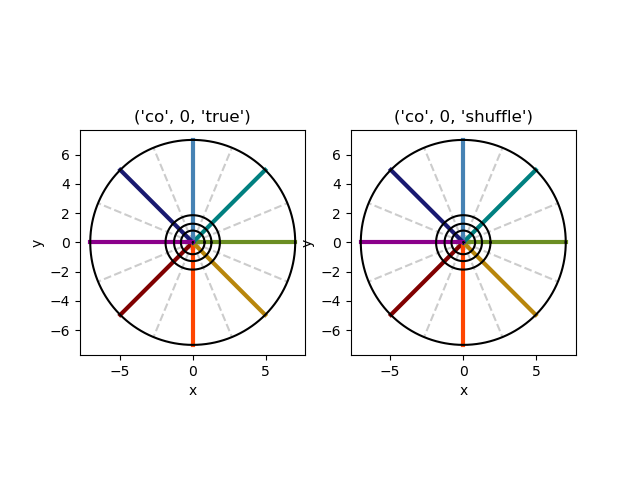

<IPython.core.display.Javascript object>


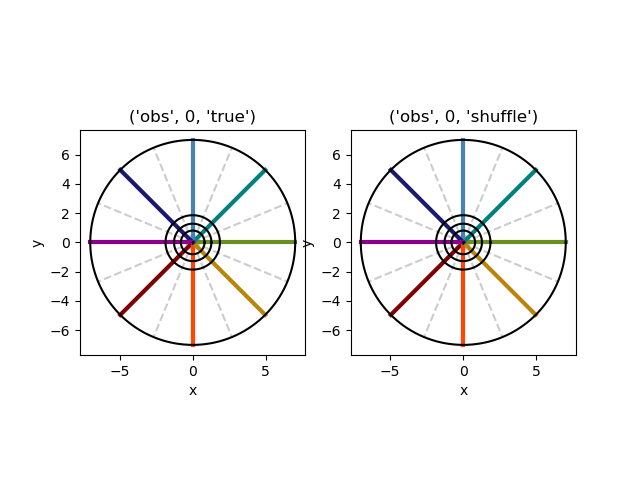

<IPython.core.display.Javascript object>


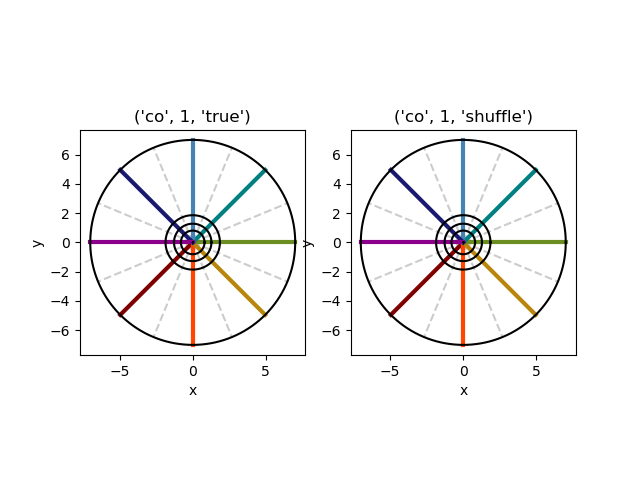

<IPython.core.display.Javascript object>


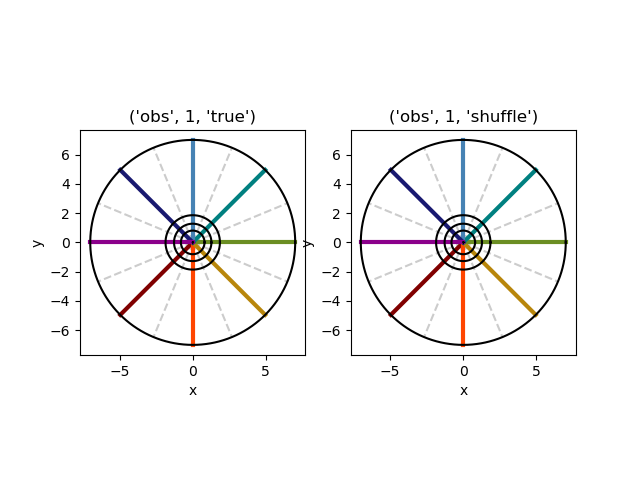

<IPython.core.display.Javascript object>


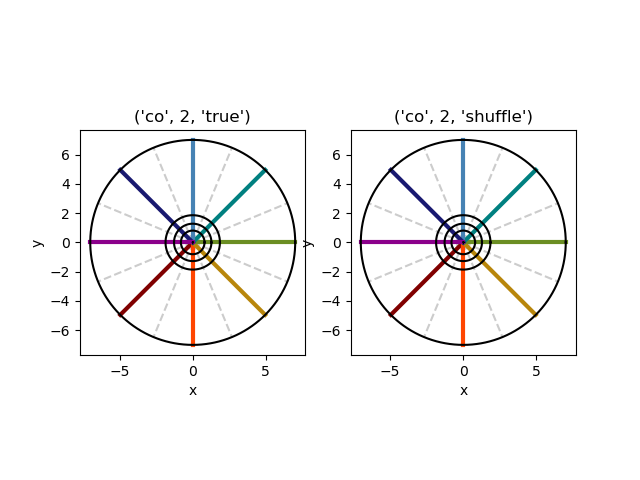

<IPython.core.display.Javascript object>


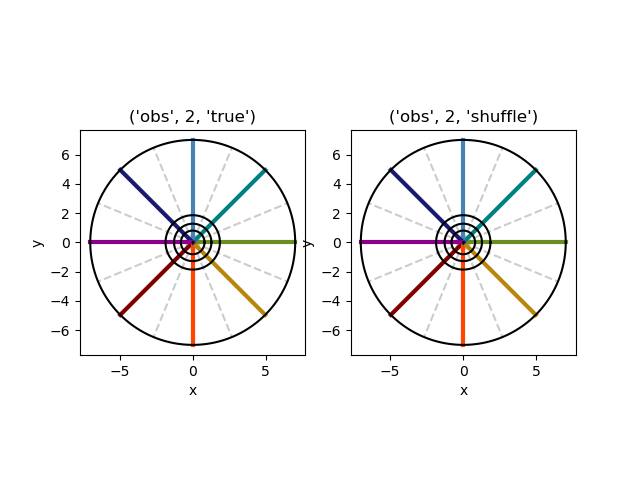

<IPython.core.display.Javascript object>


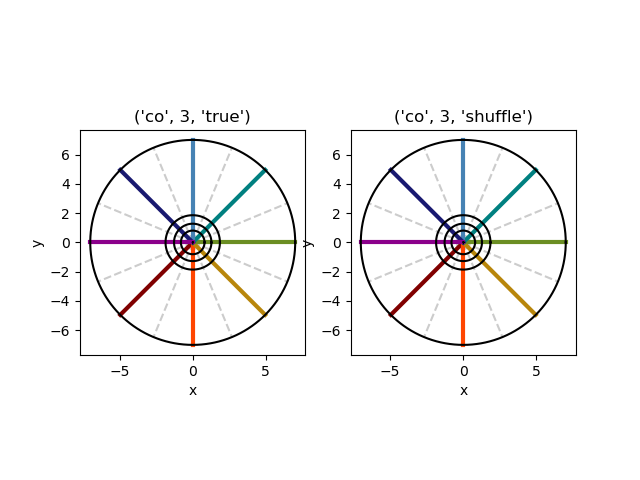

<IPython.core.display.Javascript object>


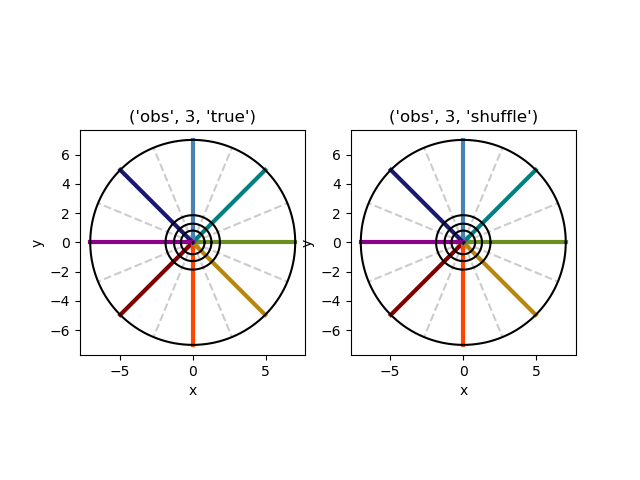

<IPython.core.display.Javascript object>


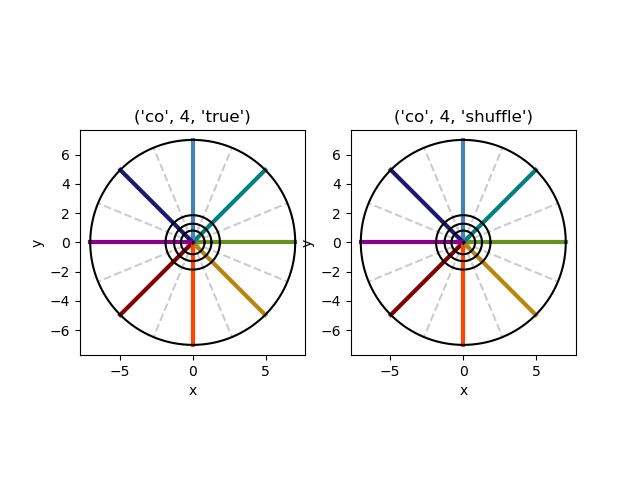

<IPython.core.display.Javascript object>


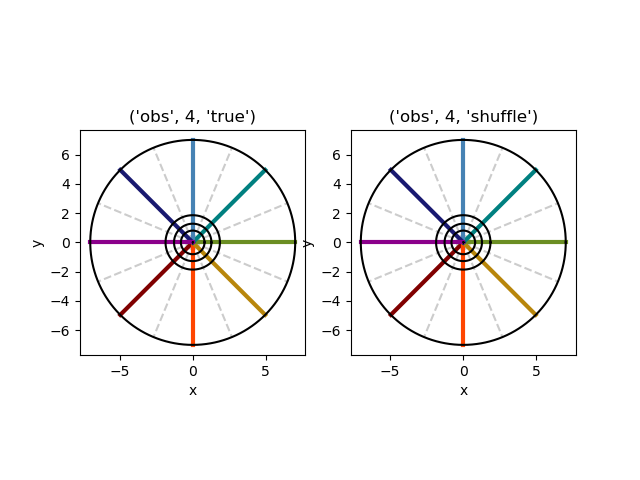

<IPython.core.display.Javascript object>


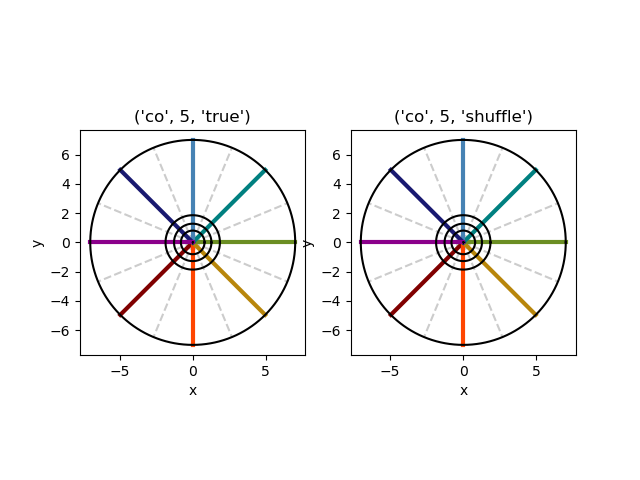

<IPython.core.display.Javascript object>


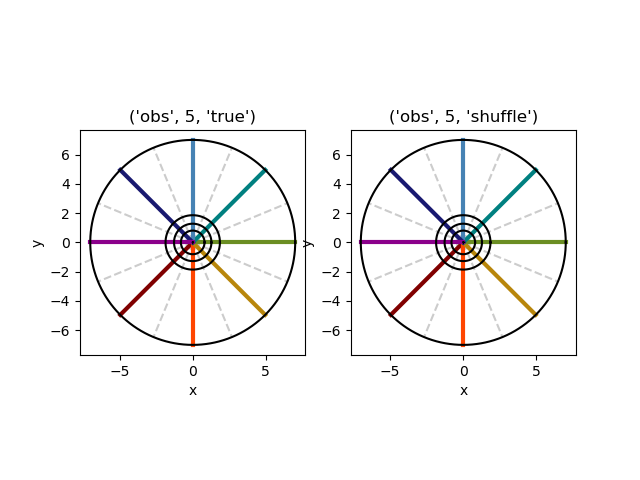

<IPython.core.display.Javascript object>


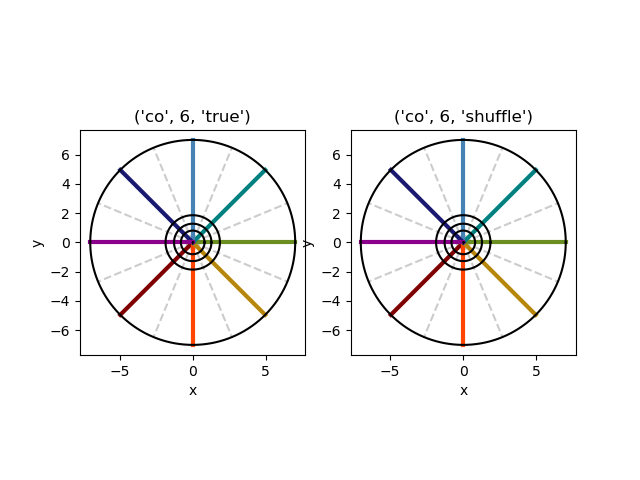

<IPython.core.display.Javascript object>


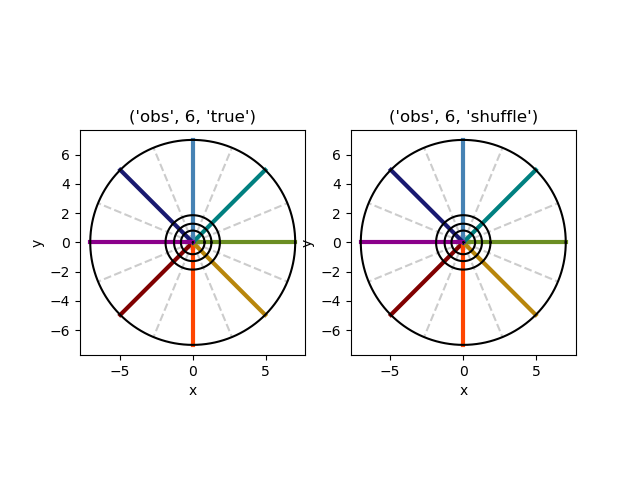

<IPython.core.display.Javascript object>


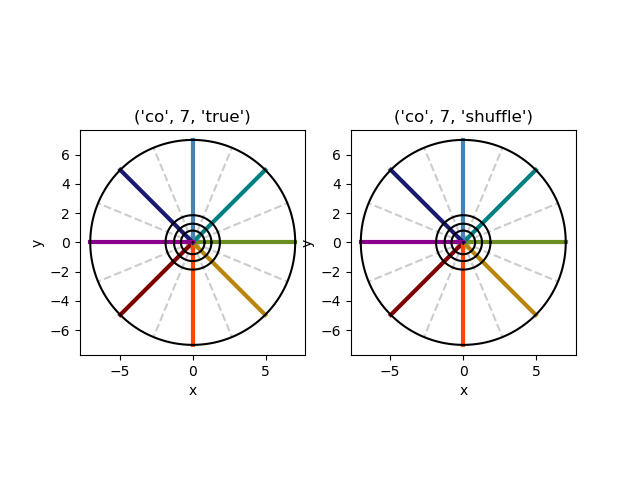

<IPython.core.display.Javascript object>


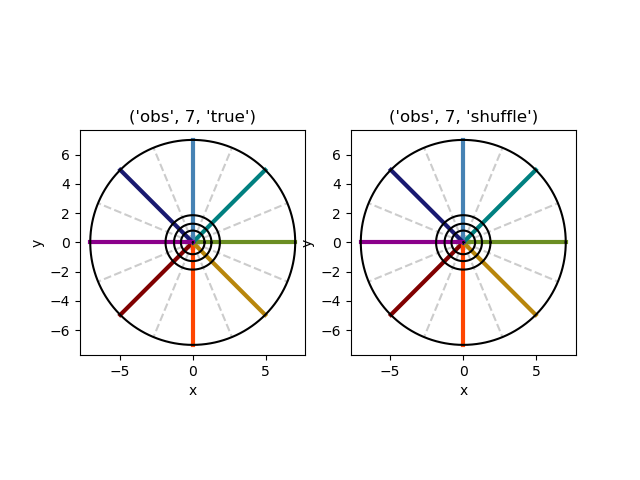

Text(0,0.5,'y')

In [69]:
#Compare true data to shuffled for a movement: 
df_list = [df, df_S]
df_label = ['true', 'shuffle']
color_by_shuffle = False
#Visualize each condition separately: 
for target in [0]:# range(num_targets):
    for task in [0]: #range(num_tasks):
        plt.figure()
        for i, df_i in enumerate(df_list):        
            plt.subplot(1,2,i+1)
            plt.title((task_list[task], target, df_label[i]))    
            plot_command_bin()        

            task_sel = (df_i['task'] == task)
            target_sel = (df_i['target'] == target)
            bin_sel = (df_i['bin']>=0)
            
            sel = task_sel & target_sel & bin_sel

            x = df_i['u_vx'][sel]
            y = df_i['u_vy'][sel]
            
            if (df_label[i] == 'shuffle') and (color_by_shuffle):
                target_shuffle = df_i.loc[sel, 'target_shuffle']
                plt.scatter(x, y,alpha=0.1,color=target_color[np.array(target_shuffle)])
            else:
                plt.scatter(x, y,alpha=0.1,color=target_color[target])

plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')

In [75]:
df_i.loc[10:20,:]

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,p_angle_ctr_t,v_angle_ctr_t,u_p_angle_ctr_t,u_v_angle_ctr_t,u_v_angle_ctr_bin,task_shuffle,tc_shuffle,target_shuffle,trial_shuffle,bin_shuffle
10,2.0,1.0,0.0,0.0,1.0,5.0,3.0,1.0,0.0,0.0,...,-1.677566,-1.883858,-2.559033,-2.559033,-2.559033,1,4378,2,48,2
11,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,...,-1.703065,-1.797372,-2.200178,-2.200178,-2.200178,1,4382,2,118,8
12,0.0,1.0,0.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,...,-1.918043,-2.763699,-3.056167,-3.056167,3.227018,1,4382,0,97,20
13,1.0,1.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0,...,-2.000404,-2.180037,-1.919489,-1.919489,-1.919489,1,4382,1,35,35
14,2.0,0.0,0.0,0.0,1.0,6.0,3.0,0.0,0.0,0.0,...,-2.095620,-2.488435,-2.802298,-2.802298,3.480887,1,4378,2,30,9
15,2.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0,...,-2.168502,-2.438708,-2.492237,-2.492237,-2.492237,1,4382,7,14,23
16,1.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,...,-2.179174,-2.190113,-1.842068,-1.842068,-1.842068,1,4382,4,74,36
17,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,-2.185797,-2.233255,-2.359741,-2.359741,-2.359741,1,4382,0,104,18
18,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,-2.233928,-2.577509,-2.867478,-2.867478,3.415707,0,4377,6,17,24
19,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,...,-2.261985,-2.451251,-2.418626,-2.418626,-2.418626,1,4382,1,68,17


In [78]:
target_shuffle

12     0
14     2
18     6
24     7
68     1
69     7
72     6
74     4
77     6
78     7
111    1
112    0
113    4
120    0
131    6
156    1
157    2
180    7
183    6
187    7
190    7
194    7
225    1
245    4
271    1
282    7
288    2
Name: target_shuffle, dtype: object

In [87]:
target_color_mat = np.zeros((num_targets, 4))
for i in range(num_targets):
    target_color_mat[i,:] = colors.to_rgba(target_color[i])
target_color_mat

# task_color =['k', 'r']
task_color =['k', 'r']
# task_color
task_color_mat = np.zeros((num_tasks,4))
for i in range(num_tasks):
    task_color_mat[i,:] = colors.to_rgba(task_color[i])
task_color_mat

<IPython.core.display.Javascript object>


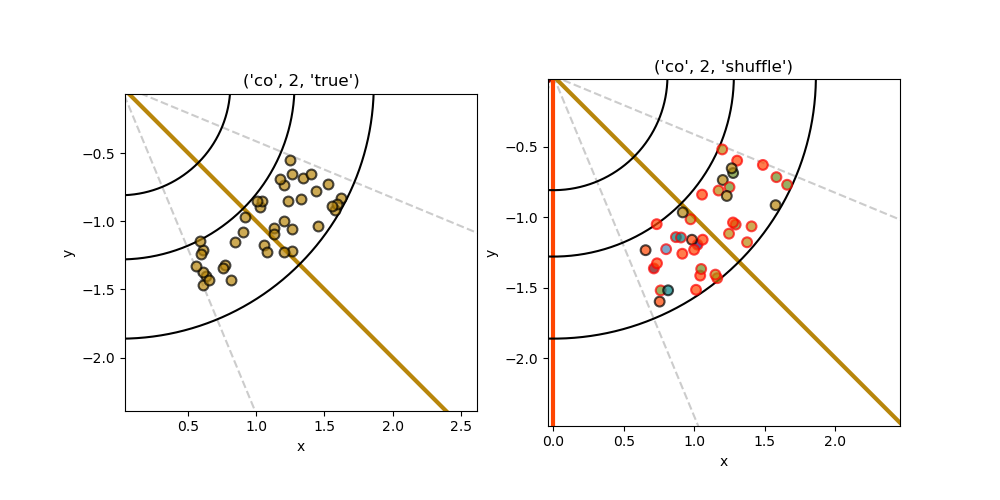

Text(0,0.5,'y')

In [128]:
#Compare true data to shuffled for a movement: 
#Pick a command bin: 
bm = 2
ba = 2

df_list = [df, df_S]
df_label = ['true', 'shuffle']

color_by_shuffle = True
alpha=0.7
markersize=50

for target in [2]: # range(num_targets): #[0]
    for task in [0]: # range(num_tasks):
        plt.figure(figsize=(10,5))
        for i, df_i in enumerate(df_list):        
            plt.subplot(1,2,i+1)
            plt.title((task_list[task], target, df_label[i]))    
            plot_command_bin()        

            task_sel = (df_i['task'] == task)
            target_sel = (df_i['target'] == target)
            bin_sel = (df_i['bin'] >= 0)
            bm_sel = (df_i['u_v_mag_bin']==bm)
            ba_sel = (df_i['u_v_angle_bin']==ba)
            sel = task_sel & target_sel & bin_sel & bm_sel & ba_sel

            x = df_i['u_vx'][sel]
            y = df_i['u_vy'][sel]
            
            if (df_label[i] == 'shuffle') and (color_by_shuffle):
                target_shuffle = np.array(df_i.loc[sel, 'target_shuffle']).astype(int)
                task_shuffle = np.array(df_i.loc[sel, 'task_shuffle']).astype(int)
                plt.scatter(x, y, s=markersize, alpha=alpha,facecolors=target_color_mat[target_shuffle],edgecolors=task_color_mat[task_shuffle], linewidth=1.5)
            elif color_by_shuffle:
                plt.scatter(x, y, s=markersize, alpha=alpha,color=target_color[target],edgecolors=task_color_mat[task],linewidth=1.5)            
            else:
                plt.scatter(x, y,alpha=alpha,color=target_color[target])            

plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')

In [48]:
#Visualize binning without looking at shuffle data: 
vis_bin=False
if vis_bin:
    
    #Visualize Tasks: 
    for task in range(num_tasks):
        plt.figure()
        plt.title(task_list[task])    
        plot_command_bin()
    #     bmi_b.plot_polar_bins(angle_bin_edges, mag_bin_edges, target_color)
        for target in range(num_targets):
                task_sel = (df['task'] == task)
                target_sel = (df['target'] == target)
                sel = task_sel & target_sel

                x = df['u_vx'][sel]
                y = df['u_vy'][sel]
                plt.scatter(x, y,alpha=0.08,color=target_color[target],zorder=1000)

    plt.axis('square')
    plt.xlabel('x')
    plt.ylabel('y')
    
    #Visualize each condition separately: 
    for target in range(num_targets): #[0]
        for task in range(num_tasks):
            plt.figure()
            plt.title((task_list[task], target))    
            plot_command_bin()        

            task_sel = (df['task'] == task)
            target_sel = (df['target'] == target)
            sel = task_sel & target_sel

            x = df['u_vx'][sel]
            y = df['u_vy'][sel]
            plt.scatter(x, y,alpha=0.1,color=target_color[target])

    plt.axis('square')
    plt.xlabel('x')
    plt.ylabel('y')
    
    
    #early middle late scatter plot
    num_phases = 3
    phases = np.linspace(0,1,num_phases+1)
    trial_phase = np.array([phases[0:-1],phases[1:]])

    phase_color = ['g', 'b', 'r'] #maroon
    for target in range(num_targets): #[0]
    #     plt.subplot(2,3,)
        for task in range(num_tasks):
            plt.figure()
            plot_command_bin()   
            plt.title((task_list[task], target))    
            for phase in range(num_phases):
    #             plt.title((task_list[task], target, 'phase: ', phase))    

                task_sel = (df['task'] == task)
                target_sel = (df['target'] == target)
                phase_sel = (df['prog'] >= trial_phase[0,phase]) & (df['prog'] <= trial_phase[1,phase])
                sel = task_sel & target_sel & phase_sel

                x = df['u_vx'][sel]
                y = df['u_vy'][sel]
                plt.scatter(x, y,alpha=0.1,color=phase_color[phase])
    # phase_color[phase])#target_color[target])
    plt.axis('square')
    plt.xlabel('x')
    plt.ylabel('y')    

### Check the mean differences

In [14]:
#NOTE: This takes some time...
n_list = ['n_'+str(i) for i in np.arange(num_neurons)]

min_trials = 5
win = [-5,5] 
num_win = win[1]-win[0]+1
num_var = len(list(df.columns))
psth_var = ['u_vx', 'u_vy', 'kin_px', 'kin_py', 'u_v_mag', 'u_v_angle_ctr_bin']

psth_var.extend(n_list)
print(psth_var)
task_pairs = [(0,0), (0,1), (1,1)]
if win[0] <= 0:
    zero_lag_idx = -win[0]

#----------------------------------------------------------------------------------------------

shuffle_label = ['true', 'shuffle']
r = {}
r['true','df'] = df
r['shuffle','df'] = df_S

for i,s_label in enumerate(shuffle_label):
    df_i = r[s_label,'df']
    task_target_bin_dic=bmi_b.calc_command_trials_dic_da(df_i, win, num_var, num_tasks, num_targets, num_mag_bins, num_angle_bins)    
    bmi_b.calc_command_psth(task_target_bin_dic, psth_var, min_trials, num_tasks, num_targets, num_mag_bins, num_angle_bins)
    #ASSIGN:
    r[s_label, 'ttbd'] = task_target_bin_dic

['u_vx', 'u_vy', 'kin_px', 'kin_py', 'u_v_mag', 'u_v_angle_ctr_bin', 'n_0', 'n_1', 'n_2', 'n_3', 'n_4', 'n_5', 'n_6', 'n_7', 'n_8', 'n_9', 'n_10', 'n_11', 'n_12', 'n_13', 'n_14', 'n_15', 'n_16', 'n_17', 'n_18', 'n_19', 'n_20', 'n_21', 'n_22', 'n_23', 'n_24', 'n_25', 'n_26', 'n_27', 'n_28', 'n_29', 'n_30', 'n_31', 'n_32', 'n_33', 'n_34', 'n_35', 'n_36', 'n_37', 'n_38', 'n_39', 'n_40', 'n_41', 'n_42', 'n_43']
(0, 0, 0, 0, 8)
(0, 0, 0, 1, 3)
(0, 0, 0, 2, 2)
(0, 0, 0, 3, 3)
(0, 0, 0, 4, 0)
(0, 0, 0, 5, 1)
(0, 0, 0, 6, 2)
(0, 0, 0, 7, 5)
(0, 0, 1, 0, 10)
(0, 0, 1, 1, 7)
(0, 0, 1, 2, 2)
(0, 0, 1, 3, 1)
(0, 0, 1, 4, 0)
(0, 0, 1, 5, 1)
(0, 0, 1, 6, 2)
(0, 0, 1, 7, 3)
(0, 0, 2, 0, 19)
(0, 0, 2, 1, 5)
(0, 0, 2, 2, 2)
(0, 0, 2, 3, 0)
(0, 0, 2, 4, 0)
(0, 0, 2, 5, 2)
(0, 0, 2, 6, 0)
(0, 0, 2, 7, 11)
(0, 0, 3, 0, 29)
(0, 0, 3, 1, 3)
(0, 0, 3, 2, 0)
(0, 0, 3, 3, 0)
(0, 0, 3, 4, 0)
(0, 0, 3, 5, 1)
(0, 0, 3, 6, 1)
(0, 0, 3, 7, 17)
(0, 1, 0, 0, 14)
(0, 1, 0, 1, 14)
(0, 1, 0, 2, 19)
(0, 1, 0, 3, 8)
(0, 1

(1, 6, 3, 5, 146)
(1, 6, 3, 6, 90)
(1, 6, 3, 7, 60)
(1, 7, 0, 0, 11)
(1, 7, 0, 1, 8)
(1, 7, 0, 2, 3)
(1, 7, 0, 3, 2)
(1, 7, 0, 4, 2)
(1, 7, 0, 5, 3)
(1, 7, 0, 6, 4)
(1, 7, 0, 7, 3)
(1, 7, 1, 0, 19)
(1, 7, 1, 1, 5)
(1, 7, 1, 2, 2)
(1, 7, 1, 3, 0)
(1, 7, 1, 4, 0)
(1, 7, 1, 5, 3)
(1, 7, 1, 6, 8)
(1, 7, 1, 7, 22)
(1, 7, 2, 0, 34)
(1, 7, 2, 1, 9)
(1, 7, 2, 2, 0)
(1, 7, 2, 3, 0)
(1, 7, 2, 4, 1)
(1, 7, 2, 5, 4)
(1, 7, 2, 6, 17)
(1, 7, 2, 7, 55)
(1, 7, 3, 0, 96)
(1, 7, 3, 1, 1)
(1, 7, 3, 2, 0)
(1, 7, 3, 3, 1)
(1, 7, 3, 4, 0)
(1, 7, 3, 5, 40)
(1, 7, 3, 6, 72)
(1, 7, 3, 7, 139)
(0, 0, 0, 0, 8)
(0, 0, 0, 1, 3)
(0, 0, 0, 2, 2)
(0, 0, 0, 3, 3)
(0, 0, 0, 4, 0)
(0, 0, 0, 5, 1)
(0, 0, 0, 6, 2)
(0, 0, 0, 7, 5)
(0, 0, 1, 0, 10)
(0, 0, 1, 1, 7)
(0, 0, 1, 2, 2)
(0, 0, 1, 3, 1)
(0, 0, 1, 4, 0)
(0, 0, 1, 5, 1)
(0, 0, 1, 6, 2)
(0, 0, 1, 7, 3)
(0, 0, 2, 0, 19)
(0, 0, 2, 1, 5)
(0, 0, 2, 2, 2)
(0, 0, 2, 3, 0)
(0, 0, 2, 4, 0)
(0, 0, 2, 5, 2)
(0, 0, 2, 6, 0)
(0, 0, 2, 7, 11)
(0, 0, 3, 0, 29)
(0, 0, 3, 1, 3)
(0, 0

(1, 6, 2, 6, 24)
(1, 6, 2, 7, 25)
(1, 6, 3, 0, 22)
(1, 6, 3, 1, 0)
(1, 6, 3, 2, 0)
(1, 6, 3, 3, 0)
(1, 6, 3, 4, 0)
(1, 6, 3, 5, 146)
(1, 6, 3, 6, 90)
(1, 6, 3, 7, 60)
(1, 7, 0, 0, 11)
(1, 7, 0, 1, 8)
(1, 7, 0, 2, 3)
(1, 7, 0, 3, 2)
(1, 7, 0, 4, 2)
(1, 7, 0, 5, 3)
(1, 7, 0, 6, 4)
(1, 7, 0, 7, 3)
(1, 7, 1, 0, 19)
(1, 7, 1, 1, 5)
(1, 7, 1, 2, 2)
(1, 7, 1, 3, 0)
(1, 7, 1, 4, 0)
(1, 7, 1, 5, 3)
(1, 7, 1, 6, 8)
(1, 7, 1, 7, 22)
(1, 7, 2, 0, 34)
(1, 7, 2, 1, 9)
(1, 7, 2, 2, 0)
(1, 7, 2, 3, 0)
(1, 7, 2, 4, 1)
(1, 7, 2, 5, 4)
(1, 7, 2, 6, 17)
(1, 7, 2, 7, 55)
(1, 7, 3, 0, 96)
(1, 7, 3, 1, 1)
(1, 7, 3, 2, 0)
(1, 7, 3, 3, 1)
(1, 7, 3, 4, 0)
(1, 7, 3, 5, 40)
(1, 7, 3, 6, 72)
(1, 7, 3, 7, 139)


In [35]:
task_pairs = [(0,0), (0,1), (1,1)]
min_trials = 5
min_trials_list = [15, 30]
#n_list: list of the variable names for neural activity

for i,s_label in enumerate(shuffle_label): #shuffle_label
    ttbd = r[s_label, 'ttbd']
    diff_df = bmi_b.diff_n_lag0_b_psth_for_command_condition_pair(\
        ttbd, task_pairs, num_tasks, num_targets, num_mag_bins, num_angle_bins, min_trials, n_list)
    sel_dic, move_list = bmi_b.diff_df_sel(diff_df, min_trials_list, num_mag_bins, p_sig=0.05)
    r[s_label, 'diff_df'] = diff_df
    r[s_label, 'sel_dic'] = sel_dic
    r[s_label, 'move_list'] = move_list

(0, 0, 0, 0)
(0, 0, 0, 1)
(0, 0, 0, 2)
(0, 0, 0, 3)
(0, 0, 0, 4)
(0, 0, 0, 5)
(0, 0, 0, 6)
(0, 0, 0, 7)
(0, 1, 0, 1)
(0, 1, 0, 2)
(0, 1, 0, 3)
(0, 1, 0, 4)
(0, 1, 0, 5)
(0, 1, 0, 6)
(0, 1, 0, 7)
(0, 2, 0, 2)
(0, 2, 0, 3)
(0, 2, 0, 4)
(0, 2, 0, 5)
(0, 2, 0, 6)
(0, 2, 0, 7)
(0, 3, 0, 3)
(0, 3, 0, 4)
(0, 3, 0, 5)
(0, 3, 0, 6)
(0, 3, 0, 7)
(0, 4, 0, 4)
(0, 4, 0, 5)
(0, 4, 0, 6)
(0, 4, 0, 7)
(0, 5, 0, 5)
(0, 5, 0, 6)
(0, 5, 0, 7)
(0, 6, 0, 6)
(0, 6, 0, 7)
(0, 7, 0, 7)
(0, 0, 1, 0)
(0, 0, 1, 1)
(0, 0, 1, 2)
(0, 0, 1, 3)
(0, 0, 1, 4)
(0, 0, 1, 5)
(0, 0, 1, 6)
(0, 0, 1, 7)
(0, 1, 1, 0)
(0, 1, 1, 1)
(0, 1, 1, 2)
(0, 1, 1, 3)
(0, 1, 1, 4)
(0, 1, 1, 5)
(0, 1, 1, 6)
(0, 1, 1, 7)
(0, 2, 1, 0)
(0, 2, 1, 1)
(0, 2, 1, 2)
(0, 2, 1, 3)
(0, 2, 1, 4)
(0, 2, 1, 5)
(0, 2, 1, 6)
(0, 2, 1, 7)
(0, 3, 1, 0)
(0, 3, 1, 1)
(0, 3, 1, 2)
(0, 3, 1, 3)
(0, 3, 1, 4)
(0, 3, 1, 5)
(0, 3, 1, 6)
(0, 3, 1, 7)
(0, 4, 1, 0)
(0, 4, 1, 1)
(0, 4, 1, 2)
(0, 4, 1, 3)
(0, 4, 1, 4)
(0, 4, 1, 5)
(0, 4, 1, 6)
(0, 4, 1, 7)
(0, 5, 1, 0)

<IPython.core.display.Javascript object>


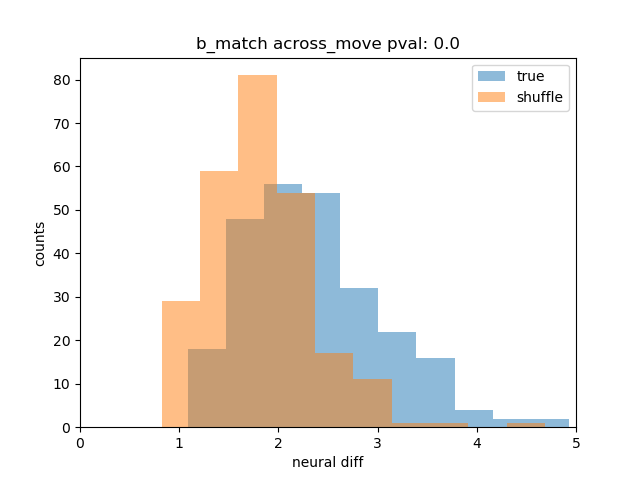

<IPython.core.display.Javascript object>


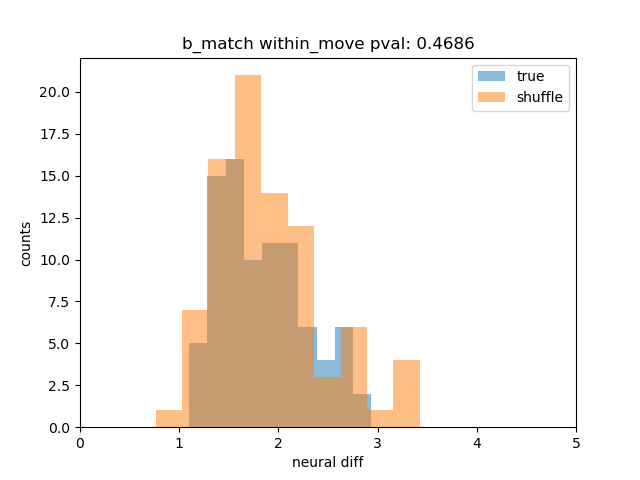

<IPython.core.display.Javascript object>


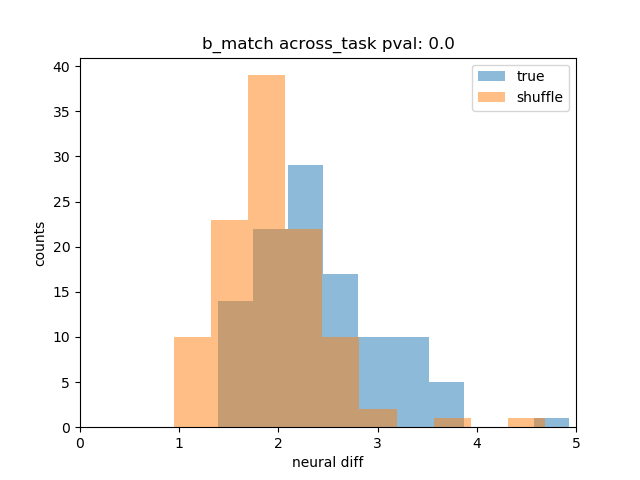

<IPython.core.display.Javascript object>


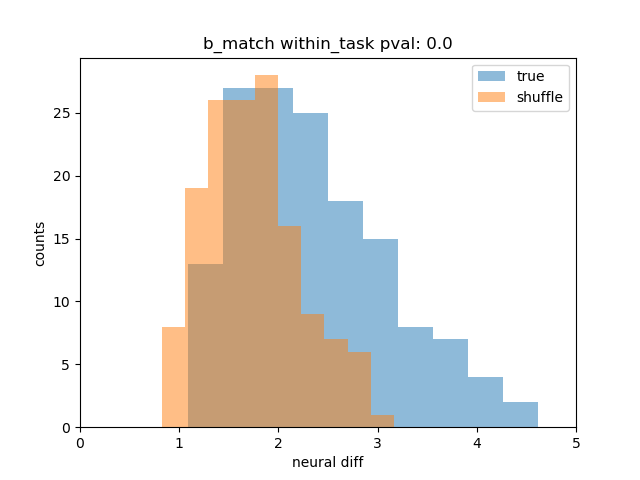

<IPython.core.display.Javascript object>


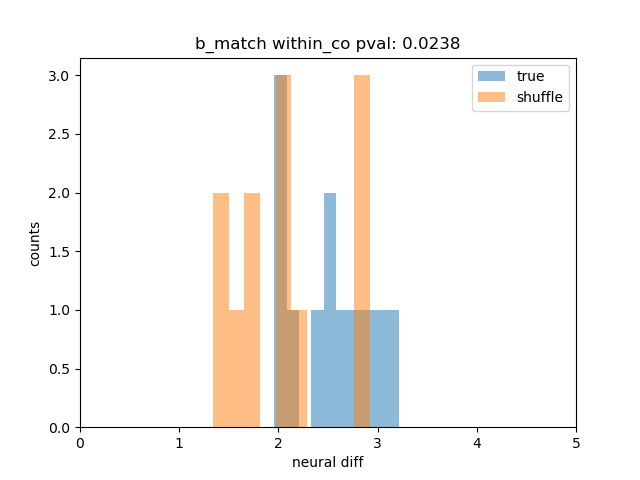

<IPython.core.display.Javascript object>


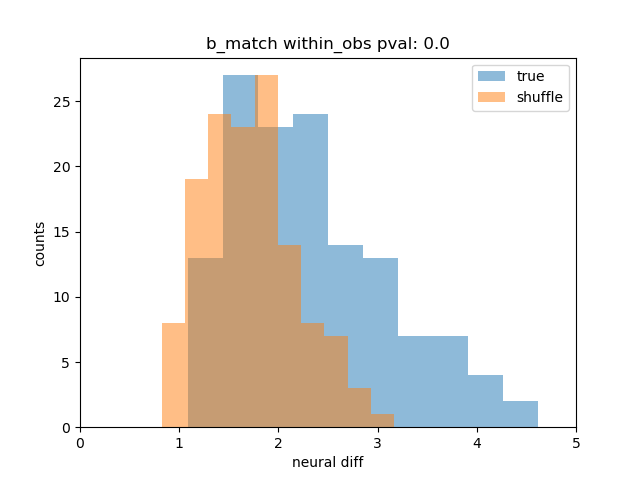

In [129]:
move_plot = ['across_move', 'within_move', 'across_task', 'within_task', 'within_co', 'within_obs']

b_match = 'b_match' #['b_all', 'b_match', 'b_not_match']

min_trials_analyze = 15
for move in move_plot:
    plt.figure()
    data_list = []
    for i,label_i in enumerate(shuffle_label):
        #unpack:
        sel_dic = r[label_i, 'sel_dic']
        diff_df = r[label_i, 'diff_df']
        
        #TRIALS
        if move == 'within_move':
            sel_trials = sel_dic['num_trials', min_trials_analyze*2]
        else:
            sel_trials = sel_dic['num_trials', min_trials_analyze]
        
        #Intra-Command Behavior Differences: 
        sel = \
            sel_trials&\
            sel_dic[move]
        if b_match == 'b_match':
            sel_b = (~sel_dic['mag_angle_sig'])
            sel = sel&sel_b
        elif b_match == 'b_not_match':
            sel_b = (sel_dic['mag_angle_sig'])

        #ASSIGN+PLOT:
        d_i = diff_df.loc[sel,'n_diff_norm']
        data_list.append(np.array(d_i))
        plt.hist(d_i,alpha=0.5,label=label_i) 
        
    (tstat,pval) = sio_stat.ttest_ind(data_list[0], data_list[1], equal_var=True)
    plt.xlim([0,5])
    plt.xlabel('neural diff')
    plt.ylabel('counts')
    plt.title(b_match + ' ' + move + ' pval: ' + str(round(pval,4)))
    plt.legend()
    

### Test data shuffle:

In [ ]:
#loop commands... re-assign the label? 

In [34]:
df_S = copy.deepcopy(df)

In [35]:
list(df_S.columns)

['n_0',
 'n_1',
 'n_2',
 'n_3',
 'n_4',
 'n_5',
 'n_6',
 'n_7',
 'n_8',
 'n_9',
 'n_10',
 'n_11',
 'n_12',
 'n_13',
 'n_14',
 'n_15',
 'n_16',
 'n_17',
 'n_18',
 'n_19',
 'n_20',
 'n_21',
 'n_22',
 'n_23',
 'n_24',
 'n_25',
 'n_26',
 'n_27',
 'n_28',
 'n_29',
 'n_30',
 'n_31',
 'n_32',
 'n_33',
 'n_34',
 'n_35',
 'n_36',
 'n_37',
 'n_38',
 'n_39',
 'n_40',
 'n_41',
 'n_42',
 'n_43',
 'u_px',
 'u_py',
 'u_vx',
 'u_vy',
 'kin_px',
 'kin_py',
 'kin_vx',
 'kin_vy',
 'task',
 'tc',
 'target',
 'trial',
 'bin',
 'trial_start',
 'trial_stop',
 'target_size',
 'obs_size',
 'bin_end',
 'prog',
 'trial_cond',
 'p_mag',
 'p_angle',
 'v_mag',
 'v_angle',
 'u_p_mag',
 'u_p_angle',
 'u_v_mag',
 'u_v_angle',
 'p_angle_ctr_t',
 'v_angle_ctr_t',
 'u_p_angle_ctr_t',
 'u_v_angle_ctr_t',
 'd2target',
 'x_error',
 'y_error',
 'u_v_mag_bin',
 'u_v_angle_bin',
 'u_v_angle_ctr_bin']

In [ ]:
var_shuffle = n_list+\
['u_px', 'u_py', 'u_vx', 'u_vy']
['u_p_mag', 'u_p_angle', 'u_v_mag', 'u_v_angle']

#Need to recalculate: 
# 'u_v_angle_ctr_bin'
# 'u_v_angle_ctr_t'
# 'u_p_angle_ctr_t'

In [121]:
#Use below to do the shuffle: 
#choose the rows to shuffle
#choose the columns to shuffle


bm = 0
ba = 0
sel = \
(df_S.loc[:,'u_v_mag_bin']==bm)\
&(df_S.loc[:,'u_v_angle_bin']==ba)\
&(df_S.loc[:,'bin']>=0)\

var_shuffle = n_list+\
['u_px', 'u_py', 'u_vx', 'u_vy']
['u_p_mag', 'u_p_angle', 'u_v_mag', 'u_v_angle']
#Need to recalculate after shuffle: 
# 'u_v_angle_ctr_bin'
# 'u_v_angle_ctr_t'
# 'u_p_angle_ctr_t'

temp = df_S.loc[sel, var_shuffle].sample(frac=1).reset_index(drop=True)

df_S.loc[sel, var_shuffle] = np.array(temp)



In [122]:
np.where(sel)[0]

array([   11,    21,    50,    71,    83,   119,   162,   193,   197,
         210,   244,   252,   263,   318,   345,   360,   376,   378,
         424,   426,   436,   471,   486,   497,   515,   549,   588,
         591,   596,   609,   610,   654,   678,   746,   761,   781,
         793,   808,   816,   861,   868,   905,   914,   921,   940,
         944,   974,  1027,  1067,  1073,  1189,  1312,  1362,  1430,
        1521,  1523,  1610,  1640,  1682,  1700,  1781,  1817,  2009,
        2011,  2226,  2233,  2248,  2340,  2361,  2426,  2633,  2758,
        2834,  3016,  3038,  3131,  3162,  3254,  3306,  3307,  3394,
        3421,  3480,  3523,  3527,  3560,  3596,  3597,  3669,  3683,
        3715,  3727,  3761,  3861,  3863,  3891,  3912,  3945,  3974,
        4022,  4030,  4051,  4067,  4087,  4090,  4109,  4176,  4251,
        4276,  4302,  4350,  4387,  4407,  4436,  4452,  4465,  4492,
        4499,  4504,  4537,  4637,  4679,  4766,  4871,  4901,  4908,
        4971,  4972,

In [53]:
i=22 #11

In [54]:
df_S.loc[i,['u_vx', 'u_vy', 'u_v_mag_bin', 'u_v_angle_bin']]

u_vx            -0.744897
u_vy            -1.361033
u_v_mag_bin      2.000000
u_v_angle_bin    0.000000
Name: 22, dtype: float64

In [55]:
df.loc[i,['u_vx', 'u_vy', 'u_v_mag_bin', 'u_v_angle_bin']]

u_vx            -0.744897
u_vy            -1.361033
u_v_mag_bin      2.000000
u_v_angle_bin    0.000000
Name: 22, dtype: float64

In [39]:
df.head(20)

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,p_angle_ctr_t,v_angle_ctr_t,u_p_angle_ctr_t,u_v_angle_ctr_t,d2target,x_error,y_error,u_v_mag_bin,u_v_angle_bin,u_v_angle_ctr_bin
0,2.0,1.0,0.0,0.0,1.0,4.0,2.0,0.0,0.0,0.0,...,3.089594,-2.668033,-2.023787,-2.023787,18.560671,13.435452,12.805746,1.0,5.0,0.332407
1,2.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,3.107998,-2.663977,-2.583228,-2.583228,18.844048,13.533209,13.112986,3.0,5.0,-0.227033
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,3.122842,-2.811559,-2.819171,-2.819171,19.180040,13.683511,13.440069,2.0,4.0,0.322422
3,5.0,0.0,0.0,1.0,0.0,4.0,4.0,0.0,0.0,0.0,...,3.121874,2.781544,0.747523,0.747523,19.319563,13.790328,13.530425,1.0,1.0,-0.037875
4,4.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,...,3.122433,-3.084737,-2.724196,-2.724196,19.482174,13.903848,13.646909,1.0,5.0,-0.368002
5,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,3.112779,1.305933,0.642336,0.642336,19.487144,13.971448,13.584824,2.0,1.0,-0.143062
6,1.0,0.0,0.0,0.0,1.0,5.0,1.0,0.0,0.0,0.0,...,3.090562,0.928689,0.735609,0.735609,19.347643,14.014071,13.339307,2.0,1.0,-0.049789
7,0.0,1.0,0.0,0.0,1.0,4.0,2.0,0.0,0.0,0.0,...,0.785549,0.761020,0.507489,0.507489,9.780188,7.071115,6.756582,2.0,1.0,-0.277909
8,0.0,0.0,0.0,0.0,4.0,3.0,1.0,0.0,0.0,0.0,...,0.581923,0.537001,-0.047721,-0.047721,9.778908,7.017324,6.810594,1.0,0.0,-0.047721
9,2.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.728406,0.971275,1.311527,1.311527,9.636667,7.042905,6.577449,1.0,2.0,-0.259270


In [105]:
exam_data = {'name': ['Anastasia', 'Dima', 'Katherine', 'James', 'Emily', 'Michael', 'Matthew', 'Laura', 'Kevin', 'Jonas'],
        'score': [12.5, 9, 16.5, np.nan, 9, 20, 14.5, np.nan, 8, 19],
        'attempts': [1, 3, 2, 3, 2, 3, 1, 1, 2, 1],
        'qualify': ['yes', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'no', 'yes']}
test = pd.DataFrame(exam_data)

In [106]:
test

,attempts,name,qualify,score
0,1,Anastasia,yes,12.5
1,3,Dima,no,9.0
2,2,Katherine,yes,16.5
3,3,James,no,NaN
4,2,Emily,no,9.0
5,3,Michael,yes,20.0
6,1,Matthew,yes,14.5
7,1,Laura,no,NaN
8,2,Kevin,no,8.0
9,1,Jonas,yes,19.0


In [107]:
q_sel = test.loc[:,'qualify']=='yes'
test2 = test.loc[q_sel,['attempts', 'name']].sample(frac=1).reset_index(drop=True)
test3=copy.copy(test)
test3.loc[q_sel,['attempts', 'name']] = test2


In [108]:
test2

,attempts,name
0,3,Michael
1,1,Anastasia
2,2,Katherine
3,1,Jonas
4,1,Matthew


In [110]:
q_sel

0     True
1    False
2     True
3    False
4    False
5     True
6     True
7    False
8    False
9     True
Name: qualify, dtype: bool

In [111]:
test3.loc[q_sel, ['attempts', 'name']]

,attempts,name
0,3.0,Michael
2,2.0,Katherine
5,NaN,NaN
6,NaN,NaN
9,NaN,NaN


In [112]:
test2

,attempts,name
0,3,Michael
1,1,Anastasia
2,2,Katherine
3,1,Jonas
4,1,Matthew


In [116]:
test3.loc[q_sel, ['attempts', 'name']] = np.zeros((5,2))

In [118]:
test3.loc[q_sel, ['attempts', 'name']] = np.array(test2)

In [119]:
test3.loc[q_sel, ['attempts', 'name']]

,attempts,name
0,3.0,Michael
2,1.0,Anastasia
5,2.0,Katherine
6,1.0,Jonas
9,1.0,Matthew


In [120]:
test3

,attempts,name,qualify,score
0,3.0,Michael,yes,12.5
1,3.0,Dima,no,9.0
2,1.0,Anastasia,yes,16.5
3,3.0,James,no,NaN
4,2.0,Emily,no,9.0
5,2.0,Katherine,yes,20.0
6,1.0,Jonas,yes,14.5
7,1.0,Laura,no,NaN
8,2.0,Kevin,no,8.0
9,1.0,Matthew,yes,19.0


In [33]:
test3=copy.copy(test)
test3.loc[q_sel,['attempts', 'name']] = test2
test3

,attempts,name,qualify,score
0,3.0,Michael,yes,12.5
1,3.0,Dima,no,9.0
2,1.0,Matthew,yes,16.5
3,3.0,James,no,NaN
4,2.0,Emily,no,9.0
5,NaN,NaN,yes,20.0
6,NaN,NaN,yes,14.5
7,1.0,Laura,no,NaN
8,2.0,Kevin,no,8.0
9,NaN,NaN,yes,19.0


### compute if neural diff are significant using condition pairs where behavior are not sig diff

In [17]:
#1) Include a column in the diff_df for whether the command data are sig diff: 

task_pairs = [(0,0), (0,1), (1,1)]
min_trials = 5
min_trials_analyze = 15
#n_list: list of the variable names for neural activity

diff_df = bmi_b.diff_n_lag0_b_psth_for_command_condition_pair(\
    task_target_bin_dic, task_pairs, num_tasks, num_targets, num_mag_bins, num_angle_bins, min_trials, n_list)
sel_dic = bmi_b.diff_df_sel(diff_df, min_trials_analyze, num_mag_bins, p_sig=0.05)

(0, 0, 0, 0)
(0, 0, 0, 1)
(0, 0, 0, 2)
(0, 0, 0, 3)
(0, 0, 0, 4)
(0, 0, 0, 5)
(0, 0, 0, 6)
(0, 0, 0, 7)
(0, 1, 0, 1)
(0, 1, 0, 2)
(0, 1, 0, 3)
(0, 1, 0, 4)
(0, 1, 0, 5)
(0, 1, 0, 6)
(0, 1, 0, 7)
(0, 2, 0, 2)
(0, 2, 0, 3)
(0, 2, 0, 4)
(0, 2, 0, 5)
(0, 2, 0, 6)
(0, 2, 0, 7)
(0, 3, 0, 3)
(0, 3, 0, 4)
(0, 3, 0, 5)
(0, 3, 0, 6)
(0, 3, 0, 7)
(0, 4, 0, 4)
(0, 4, 0, 5)
(0, 4, 0, 6)
(0, 4, 0, 7)
(0, 5, 0, 5)
(0, 5, 0, 6)
(0, 5, 0, 7)
(0, 6, 0, 6)
(0, 6, 0, 7)
(0, 7, 0, 7)
(0, 0, 1, 0)
(0, 0, 1, 1)
(0, 0, 1, 2)
(0, 0, 1, 3)
(0, 0, 1, 4)
(0, 0, 1, 5)
(0, 0, 1, 6)
(0, 0, 1, 7)
(0, 1, 1, 0)
(0, 1, 1, 1)
(0, 1, 1, 2)
(0, 1, 1, 3)
(0, 1, 1, 4)
(0, 1, 1, 5)
(0, 1, 1, 6)
(0, 1, 1, 7)
(0, 2, 1, 0)
(0, 2, 1, 1)
(0, 2, 1, 2)
(0, 2, 1, 3)
(0, 2, 1, 4)
(0, 2, 1, 5)
(0, 2, 1, 6)
(0, 2, 1, 7)
(0, 3, 1, 0)
(0, 3, 1, 1)
(0, 3, 1, 2)
(0, 3, 1, 3)
(0, 3, 1, 4)
(0, 3, 1, 5)
(0, 3, 1, 6)
(0, 3, 1, 7)
(0, 4, 1, 0)
(0, 4, 1, 1)
(0, 4, 1, 2)
(0, 4, 1, 3)
(0, 4, 1, 4)
(0, 4, 1, 5)
(0, 4, 1, 6)
(0, 4, 1, 7)
(0, 5, 1, 0)

NameError: name 'diff_df_sel' is not defined

In [18]:
diff_df.head()

,n_diff_norm,b_diff_norm,b_diff_norm_lag0,mag_bin,angle_bin,task0,target0,num_trials0,u_vx0,u_vy0,...,u_vx1,u_vy1,u_vx_diff_p,u_vx_diff_tstat,u_vy_diff_p,u_vy_diff_tstat,u_v_mag_diff_p,u_v_mag_diff_tstat,u_v_angle_diff_p,u_v_angle_diff_tstat
0,4.828302,2.970741,0.052247,0,0,0,0,8,-0.341560,-0.354920,...,-0.392591,-0.366127,0.768862,0.307493,0.922411,0.101565,0.825948,-0.229710,0.762380,0.316452
1,6.847546,3.359155,0.280203,0,7,0,0,5,-0.648608,-0.210816,...,-0.609807,0.066688,0.743340,-0.359052,0.033648,-3.726843,0.577853,0.622274,0.059932,2.951924
2,4.476606,2.491471,0.153458,1,0,0,0,10,-0.829435,-0.595034,...,-0.796802,-0.744983,0.805654,-0.254333,0.336098,1.023328,0.423490,-0.843426,0.438365,-0.815546
3,5.298716,2.268155,0.210478,1,1,0,0,7,-0.105054,-1.006814,...,0.065273,-0.883162,0.357674,-1.012697,0.155196,-1.672948,0.220471,1.399761,0.373257,-0.977405
4,2.715866,1.819729,0.059696,2,0,0,0,19,-1.088690,-0.996819,...,-1.055576,-1.046488,0.780521,-0.283097,0.683529,0.414726,0.907562,-0.117857,0.711134,-0.376595


<IPython.core.display.Javascript object>


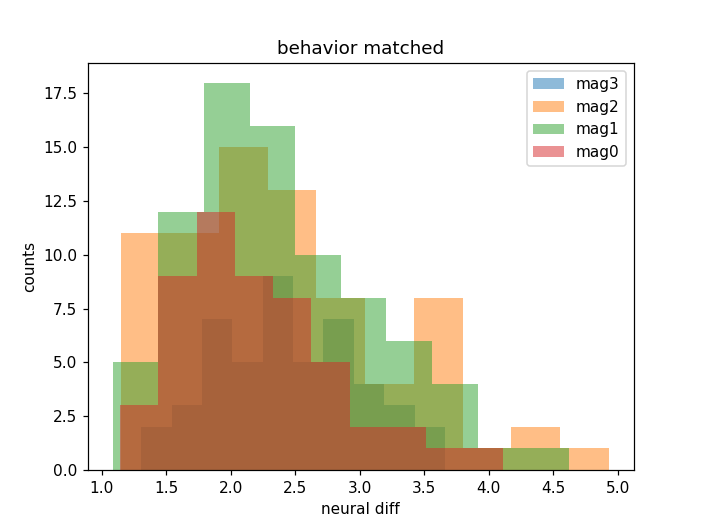

<IPython.core.display.Javascript object>


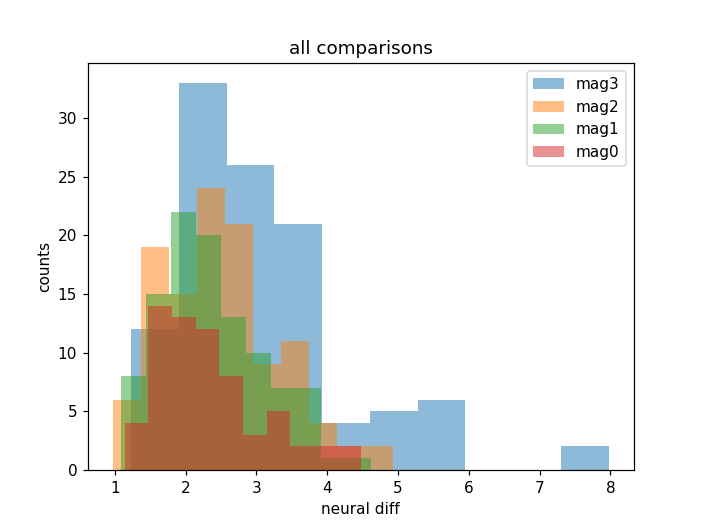

<IPython.core.display.Javascript object>


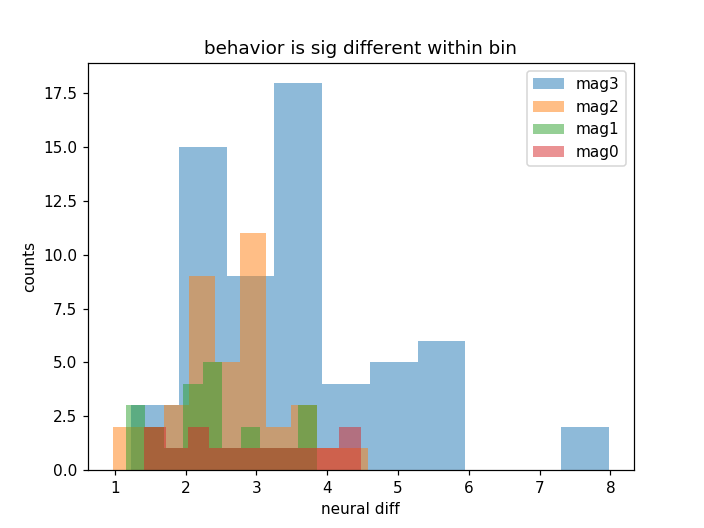

In [23]:
#PLOT:
#For a given mag, move, sig:
#the distribution over neural differences: 
move_plot = ['across_move']

#DO match behavior
for move in move_plot:
    plt.figure()
    for bm in [3,2,1,0]:
        sel = \
        sel_dic['num_trials']&\
        sel_dic[move]&\
        sel_dic['mag',bm]&\
        (~sel_dic['mag_angle_sig'])
        
        d_i = diff_df.loc[sel,'n_diff_norm']
        plt.hist(d_i,alpha=0.5,label='mag'+str(bm))
    plt.xlabel('neural diff')
    plt.ylabel('counts')
    plt.legend()
    plt.title('behavior matched')

#Don't match behavior
for move in move_plot:
    plt.figure()
    for bm in [3,2,1,0]:
        sel = sel_dic['num_trials']&\
        sel_dic[move]&\
        sel_dic[move]&\
        sel_dic['mag',bm]#&\
        #(~sel_dic['mag_angle_sig'])
        d_i = diff_df.loc[sel,'n_diff_norm']
        plt.hist(d_i,alpha=0.5,label='mag'+str(bm))
    plt.xlabel('neural diff')
    plt.ylabel('counts')
    plt.legend()
    plt.title('all comparisons')
    
#Unmatched data only:
for move in move_plot:
    plt.figure()
    for bm in [3,2,1,0]:
        sel = sel_dic['num_trials']&\
        sel_dic[move]&\
        sel_dic['mag',bm]&\
        (sel_dic['mag_angle_sig'])
        d_i = diff_df.loc[sel,'n_diff_norm']
        plt.hist(d_i,alpha=0.5,label='mag'+str(bm))
    plt.xlabel('neural diff')
    plt.ylabel('counts')
    plt.legend()
    plt.title('behavior is sig different within bin')

### compute if the behavior diffs at lag 0 are significant

In [ ]:
task_target_bin_dic[0,0,0,0]

In [ ]:
task_target_bin_dic[0,0,0,0,'psth']

In [ ]:
#Compare behavior within bin, for an example
bm = 3
ba = 5
task0 = 1
t0 = 7
task1 = 0
t1 = 4

# task0 = 1
# t0 = 7
# task1 = 1
# t1 = 3

# task0 = 0
# t0 = 5
# task1 = 1
# t1 = 5

d0 = task_target_bin_dic[task0,t0,bm,ba].loc[['u_vx', 'u_vy'],0,:]
d1 = task_target_bin_dic[task1,t1,bm,ba].loc[['u_vx', 'u_vy'],0,:]
# task_target_bin_dic[task1,t1,bm,ba]

#Run t-test: 
x0 = np.array(d0.loc['u_vx', :])
x1 = np.array(d1.loc['u_vx', :])
(tstat,pval) = scipy.stats.ttest_ind(x0, x1, equal_var=True)
print(pval)

y0 = np.array(d0.loc['u_vy', :])
y1 = np.array(d1.loc['u_vy', :])
(tstat,pval) = scipy.stats.ttest_ind(y0, y1, equal_var=True)
print(pval)

In [ ]:
plt.figure(figsize=(3,3))
plt.hist(x0)
plt.hist(x1)
plt.title('u_vx')

plt.figure(figsize=(3,3))
plt.hist(y0)
plt.hist(y1)
plt.title('u_vy')

In [ ]:
plt.figure(figsize=(5,5))
plot_command_bin()
plt.plot([0,x0.mean()], [0,y0.mean()], 'g')
plt.plot([0,x1.mean()], [0,y1.mean()], 'r')

In [ ]:
#Compare behavior within bin, for an example
# bm = 3
# ba = 5
# task0 = 1
# t0 = 7
# task1 = 1
# t1 = 3
# # task0 = 0
# # t0 = 5
# # task1 = 1
# # t1 = 5

d0 = task_target_bin_dic[task0,t0,bm,ba].loc[['u_v_mag', 'u_v_angle_ctr_bin'],0,:]
d1 = task_target_bin_dic[task1,t1,bm,ba].loc[['u_v_mag', 'u_v_angle_ctr_bin'],0,:]
# task_target_bin_dic[task1,t1,bm,ba]

#Run t-test: 
x0 = np.array(d0.loc['u_v_mag', :])
x1 = np.array(d1.loc['u_v_mag', :])
(tstat,pval) = scipy.stats.ttest_ind(x0, x1, equal_var=True)
print(pval)

y0 = np.array(d0.loc['u_v_angle_ctr_bin', :])
y1 = np.array(d1.loc['u_v_angle_ctr_bin', :])
(tstat,pval) = scipy.stats.ttest_ind(y0, y1, equal_var=True)
print(pval)

In [ ]:
plt.figure(figsize=(3,3))
plt.hist(x0)
plt.hist(x1)
plt.title('u_v_mag')

plt.figure(figsize=(3,3))
plt.hist(y0*180/np.pi)
plt.hist(y1*180/np.pi)
plt.title('u_v_angle')

In [ ]:
match_var = ['u_v_mag', 'u_v_angle_ctr_bin']

d0 = task_target_bin_dic[task0,t0,bm,ba].loc[match_var,0,:]
d1 = task_target_bin_dic[task1,t1,bm,ba].loc[match_var,0,:]
d_list = [d0, d1]

pval_sig = 0.1 #this is the pval at which mean match stops
max_iter = 20
kept_list, discard_list, df_r, ttest_r, mean_r = bmi_b.subsample_2datasets_to_match_mean(match_var, d_list, pval_sig,max_iter)
df_r

In [ ]:
mean_r.loc[['u_v_mag'],:,['mean_init', 'mean_match']]

In [ ]:
mean_r.loc[['u_v_angle_ctr_bin'],:,['mean_init', 'mean_match']]

In [ ]:
ttest_r

In [ ]:
match_var = ['u_vx', 'u_vy']

d0 = task_target_bin_dic[task0,t0,bm,ba].loc[['u_vx', 'u_vy'],0,:]
d1 = task_target_bin_dic[task1,t1,bm,ba].loc[['u_vx', 'u_vy'],0,:]
d_list = [d0, d1]

pval_sig = 0.05

kept_list, discard_list, df_r, ttest_r, mean_r = bmi_b.subsample_2datasets_to_match_mean(match_var, d_list, pval_sig)

In [ ]:
#See the histogram after mean matching:
match_var = ['u_v_mag', 'u_v_angle_ctr_bin']
d0 = task_target_bin_dic[task0,t0,bm,ba].loc[match_var,0,kept_list[0]]
d1 = task_target_bin_dic[task1,t1,bm,ba].loc[match_var,0,kept_list[1]]

#Run t-test: 
x0 = np.array(d0.loc['u_v_mag', :])
x1 = np.array(d1.loc['u_v_mag', :])
(tstat,pval) = scipy.stats.ttest_ind(x0, x1, equal_var=True)
print(pval)

y0 = np.array(d0.loc['u_v_angle_ctr_bin', :])
y1 = np.array(d1.loc['u_v_angle_ctr_bin', :])
(tstat,pval) = scipy.stats.ttest_ind(y0, y1, equal_var=True)
print(pval)

In [ ]:
plt.figure(figsize=(3,3))
plt.hist(x0)
plt.hist(x1)
plt.title('u_v_mag')

plt.figure(figsize=(3,3))
plt.hist(y0*180/np.pi, alpha=0.5)
plt.hist(y1*180/np.pi, alpha=0.5)
plt.title('u_v_angle')

In [ ]:
#The main code calculating differences across bins

In [ ]:
columns = ['n_diff_norm', 'b_diff_norm', 'b_diff_norm_lag0',
            'mag_bin', 'angle_bin', 
            'task0', 'target0', 'num_trials0', 'u_vx0', 'u_vy0',
            'task1', 'target1', 'num_trials1', 'u_vx1', 'u_vy1',
            'u_vx_diff_p', 'u_vx_diff_tstat',
            'u_vy_diff_p', 'u_vy_diff_tstat']

num_col = len(columns)
nan_df = pd.DataFrame(np.ones((1,num_col))*np.nan, columns=columns)
df_list = []
task_pairs = [(0,0), (0,1), (1,1)]
vec_diff_dic = {}

for task0, task1 in task_pairs:
    for t0 in range(num_targets):
        if task0 == task1:
            t1_set = range(t0, num_targets)
        else:
            t1_set = range(0,num_targets)
        for t1 in t1_set:
            print(task0, t0, task1, t1)
            for bm in range(num_mag_bins):
                for ba in range(num_angle_bins):
                    num_trials0 = task_target_bin_dic[task0,t0,bm,ba,'num']
                    d0_valid = num_trials0 >= min_trials
                    num_trials1 = task_target_bin_dic[task1,t1,bm,ba,'num']
                    d1_valid = num_trials1 >= min_trials                        
                    if d0_valid&d1_valid:
                        #Check if same movement: 
                        if (task0==task1)&(t0==t1):
                            #if same movement, compare psth's on different splits of data: 
                            d0 = task_target_bin_dic[task0,t0,bm,ba,'psth',0]
                            d1 = task_target_bin_dic[task0,t0,bm,ba,'psth',1]
                            
                            sel0 = task_target_bin_dic[task0,t0,bm,ba,'psth_trials', 0]
                            dd0 = task_target_bin_dic[task0,t0,bm,ba].loc[:,0,sel0]
                            sel1 = task_target_bin_dic[task0,t0,bm,ba,'psth_trials', 1]
                            dd1 = task_target_bin_dic[task1,t1,bm,ba].loc[:,0,sel1]
                        else:
                            d0 = task_target_bin_dic[task0,t0,bm,ba,'psth']
                            d1 = task_target_bin_dic[task1,t1,bm,ba,'psth']
                                                    
                            dd0 = task_target_bin_dic[task0,t0,bm,ba].loc[:,0,:]
                            dd1 = task_target_bin_dic[task1,t1,bm,ba].loc[:,0,:]                          
                            
                        #ASSIGN:
                        vec_diff_dic[bm, ba, task0, t0, task1, t1] = d0-d1
                        df_i = copy.copy(nan_df)                        
                        
                        #neural diff is over lag 0: 
                        df_i['n_diff_norm'] = np.linalg.norm(d0.loc[n_list,0]-d1.loc[n_list,0])
                        
                        #behavior diff is over all lags: 
                        df_i['b_diff_norm'] = np.linalg.norm(d0.loc[['u_vx', 'u_vy'],:]-d1.loc[['u_vx', 'u_vy'],:])
                        
                        #behavior diff is over all lags: 
                        df_i['b_diff_norm_lag0'] = np.linalg.norm(d0.loc[['u_vx', 'u_vy'],0]-d1.loc[['u_vx', 'u_vy'],0])                        
                        
                        df_i['mag_bin'] = bm
                        df_i['angle_bin'] = ba                 
                        
                        df_i['task0'] = task0
                        df_i['target0'] = t0
                        df_i['num_trials0'] = num_trials0
                        df_i['u_vx0'] = float(d0.loc['u_vx',0])
                        df_i['u_vy0'] = float(d0.loc['u_vy',0])

                        df_i['task1'] = task1
                        df_i['target1'] = t1
                        df_i['num_trials1'] = num_trials1
                        df_i['u_vx1'] = float(d1.loc['u_vx',0])
                        df_i['u_vy1'] = float(d1.loc['u_vy',0])
                        
                        #Check if behavior is significantly different within bin: 
                        #X:
                        x0 = np.array(dd0.loc['u_vx', :])
                        x1 = np.array(dd1.loc['u_vx', :])
#                         print(x0.shape, x1.shape)
                        (tstat,pval) = scipy.stats.ttest_ind(x0, x1, equal_var=True)
                        df_i['u_vx_diff_p'] = pval
                        df_i['u_vx_diff_tstat'] = tstat
                        #Y:
                        y0 = np.array(dd0.loc['u_vy', :])
                        y1 = np.array(dd1.loc['u_vy', :])
                        (tstat,pval) = scipy.stats.ttest_ind(y0, y1, equal_var=True)
                        df_i['u_vy_diff_p'] = pval
                        df_i['u_vy_diff_tstat'] = tstat                          
                        
                        #APPEND:
                        df_list.append(df_i)

diff_df = pd.concat(df_list, ignore_index=True)

In [ ]:
#Now calculate the fraction of comparisons that have sig different means.  
#Split by mag_bin, and different movement selections: 

#accumulate the differences: 
min_trials_analyze = 15

#sel: 
num_trials0_sel = (diff_df['num_trials0']>=min_trials_analyze) #5
num_trials1_sel = (diff_df['num_trials1']>=min_trials_analyze) #5

sel_universal = \
    num_trials0_sel\
    &num_trials1_sel\

sel_dic = {}
move_list = ['within_move', 'within_task', 'within_co', 'within_obs', 'across_task', 'across_move']
sel_dic['within_move'] = (diff_df['target0']==diff_df['target1'])&(diff_df['task0']==diff_df['task1'])
sel_dic['within_task'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])
sel_dic['within_co'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])&(diff_df['task0']==0)
sel_dic['within_obs'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])&(diff_df['task0']==1)
sel_dic['across_task'] = (diff_df['task0']!=diff_df['task1'])
sel_dic['across_move'] = (diff_df['task0']!=diff_df['task1'])|(diff_df['target0']!=diff_df['target1'])

mag_list = [0,1,2,3]
for bm in mag_list:
    sel_dic['mag', bm] = (diff_df['mag_bin']==bm)

diff_dic = {}
for bm in mag_list:
    for move in move_list: 
        sel = sel_universal\
        &sel_dic[move]\
        &sel_dic['mag', bm]
        diff_dic[move,bm,'u_vx'] = diff_df.loc[sel,'u_vx_diff_p']
        diff_dic[move,bm,'u_vy'] = diff_df.loc[sel,'u_vy_diff_p']
    
    

In [ ]:
move='across_task'
bm = 3
var_list = ['u_vx', 'u_vy']
for bm in mag_list:
    for var in var_list:
        print('mag:', bm, 'var:', var)
        num_sig = len(np.where(diff_dic[move,bm,var]<=0.05)[0])
        num_total = len(diff_dic[move,bm,var])
        frac_diff = float(num_sig)/num_total
        print('frac pairs sig different:', frac_diff)


In [ ]:
diff_df.head()

In [ ]:
mag_list

In [ ]:
#Show across_move, mag0 differences: 
move = 'across_move'
plt.figure(figsize=(5,5))
for bm in mag_list:
    sel = sel_universal\
    &sel_dic[move]\
    &sel_dic['mag', bm]

    x = diff_df.loc[sel,'n_diff_norm']
    y = diff_df.loc[sel,'b_diff_norm']
    plt.scatter(x,y,alpha=0.25, label='mag'+str(bm))
    plt.xlabel('n diff norm')
    plt.ylabel('b diff norm')
plt.legend()

plt.figure(figsize=(5,5))
for bm in [0]:
    sel = sel_universal\
    &sel_dic[move]\
    &sel_dic['mag', bm]

    x = diff_df.loc[sel,'n_diff_norm']
    y = diff_df.loc[sel,'b_diff_norm']
    plt.scatter(x,y,alpha=0.25, label='mag'+str(bm))
    plt.xlabel('n diff norm')
    plt.ylabel('b diff norm')
plt.legend()

In [ ]:
#Pool all differences: 
plt.figure(figsize=(5,5))
x = diff_df.loc[:,'n_diff_norm']
y = diff_df.loc[:,'b_diff_norm']
plt.scatter(x,y,alpha=0.25)
plt.xlabel('n diff norm')
plt.ylabel('b diff norm')
r,p = scipy.stats.pearsonr(x,y)
plt.title('pooling all (command, condition pairs) correlation: ' + str(round(r,2)))


In [ ]:
#Check lag0:
plt.figure(figsize=(5,5))
x = diff_df.loc[:,'n_diff_norm']
y = diff_df.loc[:,'b_diff_norm_lag0']
plt.scatter(x,y,alpha=0.25)
plt.xlabel('n diff norm')
plt.ylabel('b diff norm')
r,p = scipy.stats.pearsonr(x,y)
plt.title('pooling all (command, condition pairs) correlation: ' + str(round(r,2)))


In [ ]:
#TODO: compare: within move, within co, within obs, across task, across move: 
#Check: if the segment is just one lag behind and ahead vs 5 lags behind and ahead like I have now... 

In [ ]:
#accumulate the differences: 
min_trials_analyze = 15
max_mag=3

#sel: 
num_trials0_sel = (diff_df['num_trials0']>=min_trials_analyze) #5
num_trials1_sel = (diff_df['num_trials1']>=min_trials_analyze) #5
mag_sel = (diff_df['mag_bin']<=max_mag)

sel_universal = \
    num_trials0_sel\
    &num_trials1_sel\
    &mag_sel

move_sel_dic = {}
move_list = ['within_move', 'within_task', 'within_co', 'within_obs', 'across_task', 'across_move']
move_sel_dic['within_move', 'sel'] = (diff_df['target0']==diff_df['target1'])&(diff_df['task0']==diff_df['task1'])
move_sel_dic['within_task', 'sel'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])
move_sel_dic['within_co', 'sel'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])&(diff_df['task0']==0)
move_sel_dic['within_obs', 'sel'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])&(diff_df['task0']==1)
move_sel_dic['across_task', 'sel'] = (diff_df['task0']!=diff_df['task1'])
move_sel_dic['across_move', 'sel'] = (diff_df['task0']!=diff_df['task1'])|(diff_df['target0']!=diff_df['target1'])

for move in move_list: 
    sel = sel_universal\
    &move_sel_dic[move,'sel']
    move_sel_dic[move, 'n_diff'] = diff_df.loc[sel,'n_diff_norm']
    move_sel_dic[move, 'b_diff'] = diff_df.loc[sel,'b_diff_norm']
    move_sel_dic[move, 'b_diff_lag0'] = diff_df.loc[sel,'b_diff_norm_lag0']
    
    

In [ ]:
# move = 'within_move'
move_plot = ['within_move', 'within_task', 'across_task']
move_plot_color = ['b', 'g', 'r']
plt.figure(figsize=(5,5))
r_list = []
for i,move in enumerate(move_plot):
    x = move_sel_dic[move, 'n_diff']
    y = move_sel_dic[move, 'b_diff_lag0']
    r,p = scipy.stats.pearsonr(x,y)
    r_list.append(r)
    plt.scatter(x,y,color=move_plot_color[i],alpha=0.25,label=move + ' ' + str(round(r,2)))
    plt.axis('equal')
    plt.xlabel('n diff norm')
    plt.ylabel('b diff norm')
plt.legend()

# title_str = ''
# for i,move in enumerate(move_plot):
#     title_str += move + ' corr:' + str(round(r_list[i],2))
# plt.title(title_str)

In [ ]:
# move = 'within_move'
for move in move_list:
    x = move_sel_dic[move, 'n_diff']
    y = move_sel_dic[move, 'b_diff']
    r,p = scipy.stats.pearsonr(x,y)
    plt.figure(figsize=(5,5))
    plt.scatter(x,y,alpha=0.25)
    plt.axis('equal')
    plt.title(move + ' corr:' + str(round(r,2)))
    plt.xlabel('n diff norm')
    plt.ylabel('b diff norm')


In [ ]:
#Now choose a specific condition: 

In [ ]:
mag_bin = 3
angle_bin = 5
min_trials_analyze = 15

num_trials0_sel = (diff_df['num_trials0']>=min_trials_analyze) #5
num_trials1_sel = (diff_df['num_trials1']>=min_trials_analyze) #5
angle_sel = (diff_df['angle_bin']==angle_bin)
mag_sel = (diff_df['mag_bin']==mag_bin)
command_sel = angle_sel&mag_sel

sel_universal = \
    num_trials0_sel\
    &num_trials1_sel\
    &command_sel

sel = move_sel_dic['across_move', 'sel']&sel_universal

x = diff_df.loc[sel,'n_diff_norm']
y = diff_df.loc[sel,'b_diff_norm'] #b_diff_lag0
r,p = scipy.stats.pearsonr(x,y)

plt.figure(figsize=(5,5))
plt.scatter(x,y,alpha=0.25)
plt.axis('equal')
plt.title('corr:' + str(round(r,4)))
plt.xlabel('n diff norm')
plt.ylabel('b diff norm')

num_comparisons = len(np.where(sel)[0])
print(num_comparisons)

sel_ex = sel

In [ ]:
diff_df[sel]

In [ ]:
#Plot the trajectories compared: 
min_trials_plot = 15 #10
mag_bin_plot = 3
angle_bin = 5
sc = 0.5

#PLOT COMMAND: 

for mag_bin in [mag_bin_plot]:
    pm = mag_bin_c[mag_bin]
    pa = angle_bin_c[angle_bin]
    x_bin = pm*np.cos(pa)*sc
    y_bin = pm*np.sin(pa)*sc
    
    #-----------------------------------------------------------------------------------------------------------------
    plt.figure(figsize=(7,7))
    ax = plt.gca()
    plt.plot([0, x_bin], [0, y_bin], color=np.ones(3)*0.5, linewidth=3, label='command (scaled ' + str(sc)+')')
    task_alpha = [1, 0.5]
    for task in range(0,num_tasks):
        for target in range(0,num_targets):
            num_trials = psth_c_dic[task, target, mag_bin, angle_bin, 'num']
            if num_trials >= min_trials_plot:
                print(task, target, num_trials)
                data = psth_c_dic[task, target, mag_bin, angle_bin, 'psth']
                plt.plot(data.loc['kin_px'], data.loc['kin_py'], '.-', alpha=task_alpha[task], color=target_color[target], label=('tsk:',task,'T:',target))
                plt.plot(data.loc['kin_px', 0], data.loc['kin_py', 0], '.-', color='r', markersize=15)   
                plt.plot(data.loc['kin_px', win[1]], data.loc['kin_py', win[1]], '.-', color='r') #color=np.ones(3)*0.0
                plt.plot(data.loc['kin_px', win[0]], data.loc['kin_py', win[0]], '.-', color='g')  
    plt.axis('equal')
#     ax.set_aspect('equal')
    plt.legend()
    plt.title('command angle:'+str(round(pa*180/np.pi,2)) + ' mag:' + str(round(pm,2)))
    

In [ ]:
ex_df

In [ ]:
cond_ex = []
for i in np.arange(ex_df.shape[0]):
    row = ex_df.iloc[i]
    cond_tuple = (row['task0'], row['target0'])
    if cond_tuple not in cond_ex: 
        cond_ex.append(cond_tuple)
        
    cond_tuple = (row['task1'], row['target1'])
    if cond_tuple not in cond_ex: 
        cond_ex.append(cond_tuple)
        
print(cond_ex)
num_cond_ex = len(cond_ex)
print('number of conditions:', num_cond_ex)

In [ ]:
cond_ex

In [ ]:
np.arange(4)

In [ ]:
#Make an xarray of num_neurons x num_timepoints:
nan_mat = np.ones((num_neurons, num_cond_ex))*np.nan
da = xr.DataArray(nan_mat, coords={'var':n_list, 'cond':range(num_cond_ex)}, dims=['var','cond'])
bm = 3
ba = 5

for i,cond in enumerate(cond_ex): 
    task0 = cond[0]
    t0 = cond[1]
    da[:,i] = task_target_bin_dic[task0,t0,bm,ba,'psth'].loc[n_list,0]
    

In [ ]:
da.mean(axis=1).repeat((1,num_cond_ex)).shape

In [ ]:
plt.figure()
plt.imshow(da)

#subtract the mean: 
da_c = da-np.array(da.mean(axis=1)).reshape((-1,1)).repeat(8, axis=1)
plt.figure()
plt.imshow(da_c)

In [ ]:
task_target_bin_dic[task0,t0,bm,ba,'psth'].loc[n_list,0]

In [ ]:
                            d0 = task_target_bin_dic[task0,t0,bm,ba,'psth']
                            d1 = task_target_bin_dic[task1,t1,bm,ba,'psth']
                        
                        #ASSIGN:
                        vec_diff_dic[bm, ba, task0, t0, task1, t1] = d0-d1
                        df_i = copy.copy(nan_df)                        
                        
                        #neural diff is over lag 0: 
                        df_i['n_diff_norm'] = np.linalg.norm(d0.loc[n_list,0]-d1.loc[n_list,0])

In [ ]:
#For A condition
task0 = 0
t0 = 5
bm = 3
ba = 5

u_true = task_target_bin_dic[task0,t0,bm,ba,'psth'].loc[['u_vx', 'u_vy'],0]
n = task_target_bin_dic[task0,t0,bm,ba,'psth'].loc[n_list,0]
d=bmi_util.decompose_decoder(decoder['F'], decoder['K'])
u_test = np.dot(d['K_d']['v'], n)
vi = np.array([3,5])
print(u_test[vi])
print(u_true)
print('diff:', np.array(u_test[vi]-u_true))


In [ ]:
task_target_bin_dic[task0,t0,bm,ba,'psth'].loc[['u_vx', 'u_vy'],0]

In [ ]:
decoder.keys()

In [ ]:
decoder['K'].shape

In [ ]:
d=bmi_util.decompose_decoder(decoder['F'], decoder['K'])

In [ ]:
d['K_d']['v'].shape

In [ ]:
#FOR REFERENCE: 
#accumulate the differences: 
min_trials_analyze = 15
max_mag=3

#sel: 
num_trials0_sel = (diff_df['num_trials0']>=min_trials_analyze) #5
num_trials1_sel = (diff_df['num_trials1']>=min_trials_analyze) #5
mag_sel = (diff_df['mag_bin']<=max_mag)

sel_universal = \
    num_trials0_sel\
    &num_trials1_sel\
    &mag_sel

move_sel_dic = {}
move_list = ['within_move', 'within_task', 'within_co', 'within_obs', 'across_task', 'across_move']
move_sel_dic['within_move', 'sel'] = (diff_df['target0']==diff_df['target1'])&(diff_df['task0']==diff_df['task1'])
move_sel_dic['within_task', 'sel'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])
move_sel_dic['within_co', 'sel'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])&(diff_df['task0']==0)
move_sel_dic['within_obs', 'sel'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])&(diff_df['task0']==1)
move_sel_dic['across_task', 'sel'] = (diff_df['task0']!=diff_df['task1'])
move_sel_dic['across_move', 'sel'] = (diff_df['task0']!=diff_df['task1'])|(diff_df['target0']!=diff_df['target1'])

for move in move_list: 
    sel = sel_universal\
    &move_sel_dic[move,'sel']
    move_sel_dic[move, 'n_diff'] = diff_df.loc[sel,'n_diff_norm']
    move_sel_dic[move, 'b_diff'] = diff_df.loc[sel,'b_diff_norm']
    move_sel_dic[move, 'b_diff_lag0'] = diff_df.loc[sel,'b_diff_norm_lag0']
    
    